<font size=+3 color="#3D3D3D"><center><b>Predicting Customer Churn with Machine Learning 🏦💰</b></center></font>

<img src="https://images.unsplash.com/photo-1520033906782-1684d0e7498e?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1334&q=80" width = 600>
<center><em>Photo by Michael Jasmund (Unsplash)</em></center>

<br>

**Table of Contents**

- [Introduction](#Introduction)
- [Objective](#Objective)
- [Libraries](#Libraries)
- [Parameters and Variables](#Parameters-and-Variables)
- [Functions](#Functions)
- [A Quick Look at our Data](#A-Quick-Look-at-our-Data)
- [Creating a Test Set](#Creating-a-Test-Set)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Target Variable: Exited](#Target-Variable:-Exited)
    - [Continuous Variables](#Continuous-Variables)
    - [Categorical Variables](#Categorical-Variables)
- [Data Preprocessing](#Data-Preprocessing)
    - [Feature Selection](#Feature-Selection)
    - [Encoding Categorical Features](#Encoding-Categorical-Features)
    - [Scaling](#Scaling)
    - [Addressing Class Imbalance](#Addressing-Class-Imbalance)
- [Building Machine Learning Models](#Building-Machine-Learning-Models)
    - [Baseline Models](#Baseline-Models)
    - [Model Tuning](#Model-Tuning)
- [Results](#Results)
    - [Learning Curves](#Learning-Curves)
    - [Feature Importance](#Feature-Importance)
    - [Performance Comparison](#Performance-Comparison)
- [Evaluating the Test Set](#Evaluating-the-Test-Set)
- [Bibliography](#Bibliography)
- [Future Development](#Future-Development)
- [Conclusions](#Conclusions)
  

<br>

# Introduction


Customer churn (also known as customer attrition) occurs when a customer stops using a company's products or services. 

Customer churn affects profitability, especially in industries where revenues are heavily dependent on subscriptions (e.g. banks, telephone and internet service providers, pay-TV companies, insurance firms, etc.). It is estimated that acquiring a new customer can cost up to five times more than retaining an existing one.

Therefore, customer churn analysis is essential as it can help a business:

- identify problems in its services (e.g. poor quality product/service, poor customer support, wrong target audience, etc.), and 
- make correct strategic decisions that would lead to higher customer satisfaction and consequently higher customer retention.

If you would like to know more about this topic, please refer to the references in the [Bibliography](#Bibliography) section.

<br>

# Objective

The goal of this notebook is to understand and predict customer churn for a bank. Specifically, we will initially perform **Exploratory Data Analysis** (**EDA**) to identify and visualise the factors contributing to customer churn. This analysis will later help us build **Machine Learning** models to predict whether a customer will churn or not. 

This problem is a typical **classification** task. The task does not specify which performance metric to use for optimising our machine learning models. I decided to use **recall** since correctly classifying elements of the positive class (customers who will churn) is more critical for the bank.

<br>

*Skills: Exploratory Data Analysis, Data Visualisation, Data Preprocessing (Feature Selection, Encoding Categorical Features, Feature Scaling), Addressing Class Imbalance (SMOTE), Model Tuning.*

*Models Used: Logistic Regression, Support Vector Machines, Random Forests, Gradient Boosting, XGBoost, and Light Gradient Boosting Machine.*


<br>

# Libraries

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
np.set_printoptions(precision=3)

import pandas as pd

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

!pip install seaborn --upgrade
import seaborn as sns
sns.set_style('darkgrid')

# Statistics
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

print('✔️ Libraries Imported!')

ModuleNotFoundError: No module named 'scikitplot'

<br>

# Parameters and Variables

It is convenient to set some (default) parameters and variables for the whole notebook.  

In [4]:
font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

print('✔️ Default Parameters and Variables Set!')

✔️ Default Parameters and Variables Set!


<br>

# Functions

Since we will reuse parts of the code, it will be helpful to define some functions.

## `plot_continuous()`

In [5]:
def plot_continuous(feature):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = train_df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout();


print('✔️ Function Defined!')

✔️ Function Defined!


## `plot_categorical()`

In [6]:
def plot_categorical(feature):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=feature,
                  hue='Exited',
                  data=train_df,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Exited',
                data=train_df,
                palette=colors_cat,
                ax=ax2)
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout();


print('✔️ Function Defined!')

✔️ Function Defined!


## `plot_conf_mx()`

In [7]:
def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned']);


print('✔️ Function Defined!')

✔️ Function Defined!


## `plot_learning_curve()`

In [38]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14);


print('✔️ Function Defined!')

✔️ Function Defined!


## `clf_performance()`

In [39]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    '''Display the overall performance of a classifier with this template.'''
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=5,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout();


print('✔️ Function Defined!')

✔️ Function Defined!


## `plot_feature_imp()`

In [40]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');


print('✔️ Function Defined!')

✔️ Function Defined!


## `test_func()`

In [41]:
def test_func(classifier, classifier_name, ax):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues',
                ax=ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned']);


print('✔️ Function Defined!')

✔️ Function Defined!


<br>

# A Quick Look at our Data

We start by importing the dataset as a Pandas DataFrame. We can also take a look at the top five rows using the `head()` method:

In [42]:

url = "https://raw.githubusercontent.com/sagnikghoshcr7/Bank-Customer-Churn-Prediction/master/Churn_Modelling.csv"
df = pd.read_csv(url, header=0, index_col=0).reset_index()

print('✔️ Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

✔️ Dataset Imported Successfully!

It contains 10000 rows and 14 columns.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Our DataFrame has 14 features/attributes and 10K customers/instances. The last feature, '**Exited**', is the **target variable** and indicates whether the customer has churned (0 = No, 1 = Yes). The meaning of the rest of the features can be easily inferred from their name.

Features 'RowNumber', 'CustomerId', and 'Surname' are specific to each customer and can be dropped:

In [43]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

The `info()` method can give us valuable information such as the number of non-null values and the type of each feature:

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Thankfully, there are **no missing values** in our DataFrame. The `describe()` method gives us a statistical summary of the numerical features:

In [45]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


The most important things to note are:

- The age of customers ranges from 18 to 92, with a mean value approximately equal to 40,
- The mean (and median) tenure is 5 years, so the majority of customers is loyal (tenure > 3), and
- Approximately 50% of customers are active.

EDA will help us understand our dataset better. However, before we look at the data any further, we need to create a **test set**, put it aside, and use it only to evaluate our Machine Learning models. This practice protects our models from **data snooping bias** (you can read more on page 51 of [[1](#Bibliography)]) and ensures that evaluation will be performed using unseen data. 

<br>

# Creating a Test Set

We will split our dataset into a train and test set using scikit-learn's `train_test_split()` function, which implements random sampling. Our dataset is large enough (especially relative to the number of features), so we do **not** risk introducing *sampling bias*.

In [46]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print('Train set: {} rows x {} columns'.format(train_df.shape[0],
                                               train_df.shape[1]))
print(' Test set: {} rows x {} columns'.format(test_df.shape[0],
                                               test_df.shape[1]))

Train set: 8000 rows x 11 columns
 Test set: 2000 rows x 11 columns


<br>

# Exploratory Data Analysis

## Target Variable: Exited

As we mentioned earlier, the target variable is already encoded and can take two possible values:

- Zero (0) for a customer that has **not** churned, and
- One (1) for a customer that has churned.

/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/3700935509.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Retained', 'Churned'])


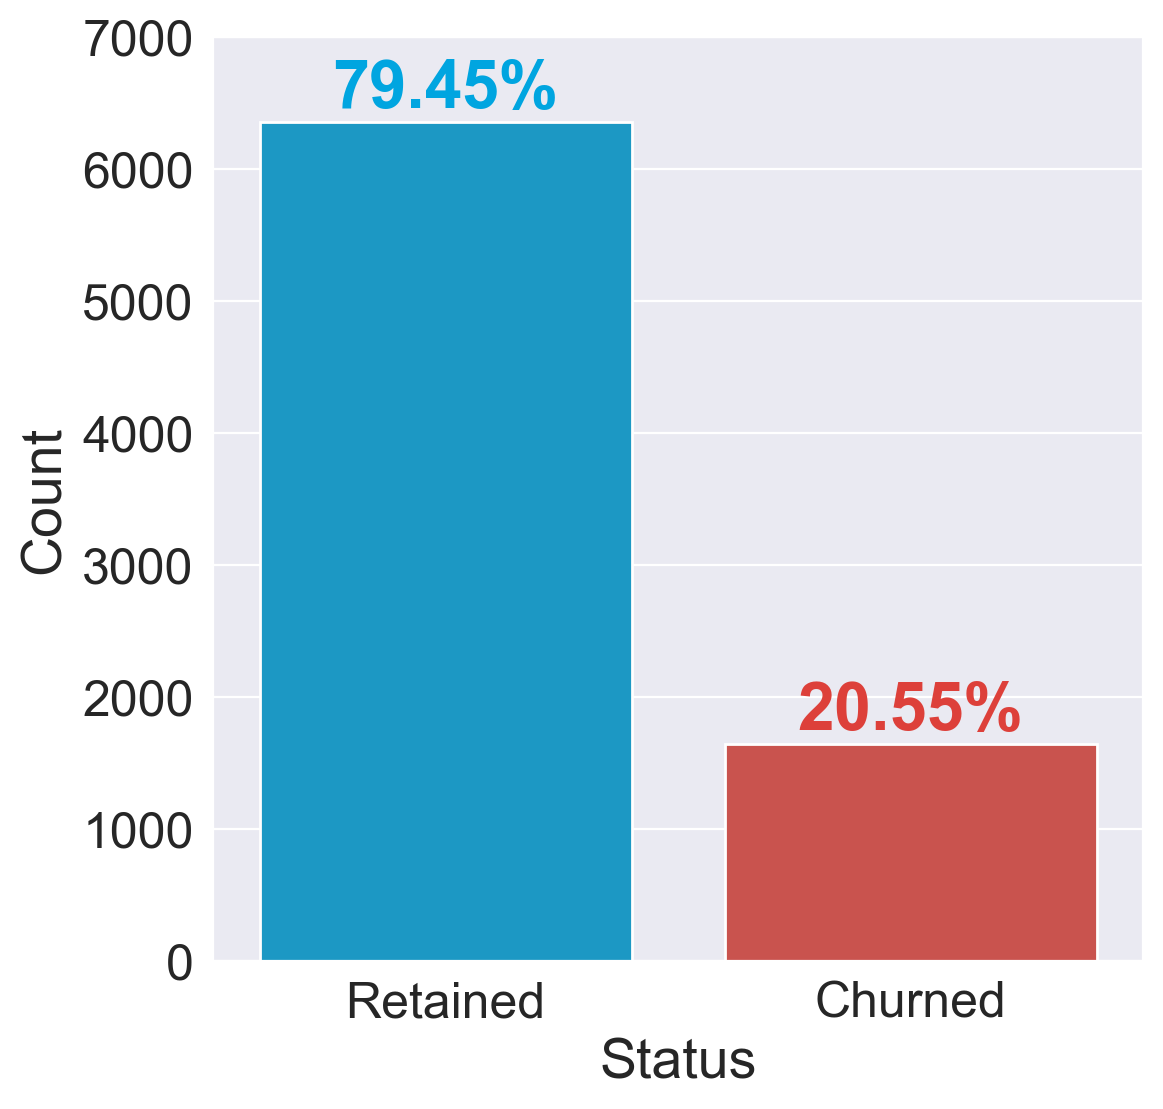

In [47]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=train_df, palette=colors, ax=ax)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label = '{}%'.format(round((value / train_df['Exited'].shape[0]) * 100, 2))
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='center',
                color=colors[index],
                fontweight='bold',
                size=font_size + 4)

ax.set_xticklabels(['Retained', 'Churned'])
ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_ylim([0, 7000]);

The bank kept 80% of its clientele.

Notice that our dataset is **skewed/imbalanced** since the number of instances in the 'Retained' class outnumbers the number of instances in the 'Churned' class by a lot. Therefore, accuracy is probably not the best metric for model performance.


Different visualisation techniques apply to different types of variables, so it's helpful to differentiate between continuous and categorical variables and look at them separately.

In [48]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


## Continuous Variables

By calling the `hist()` method, we can plot a histogram for each of the four continuous numeric features:

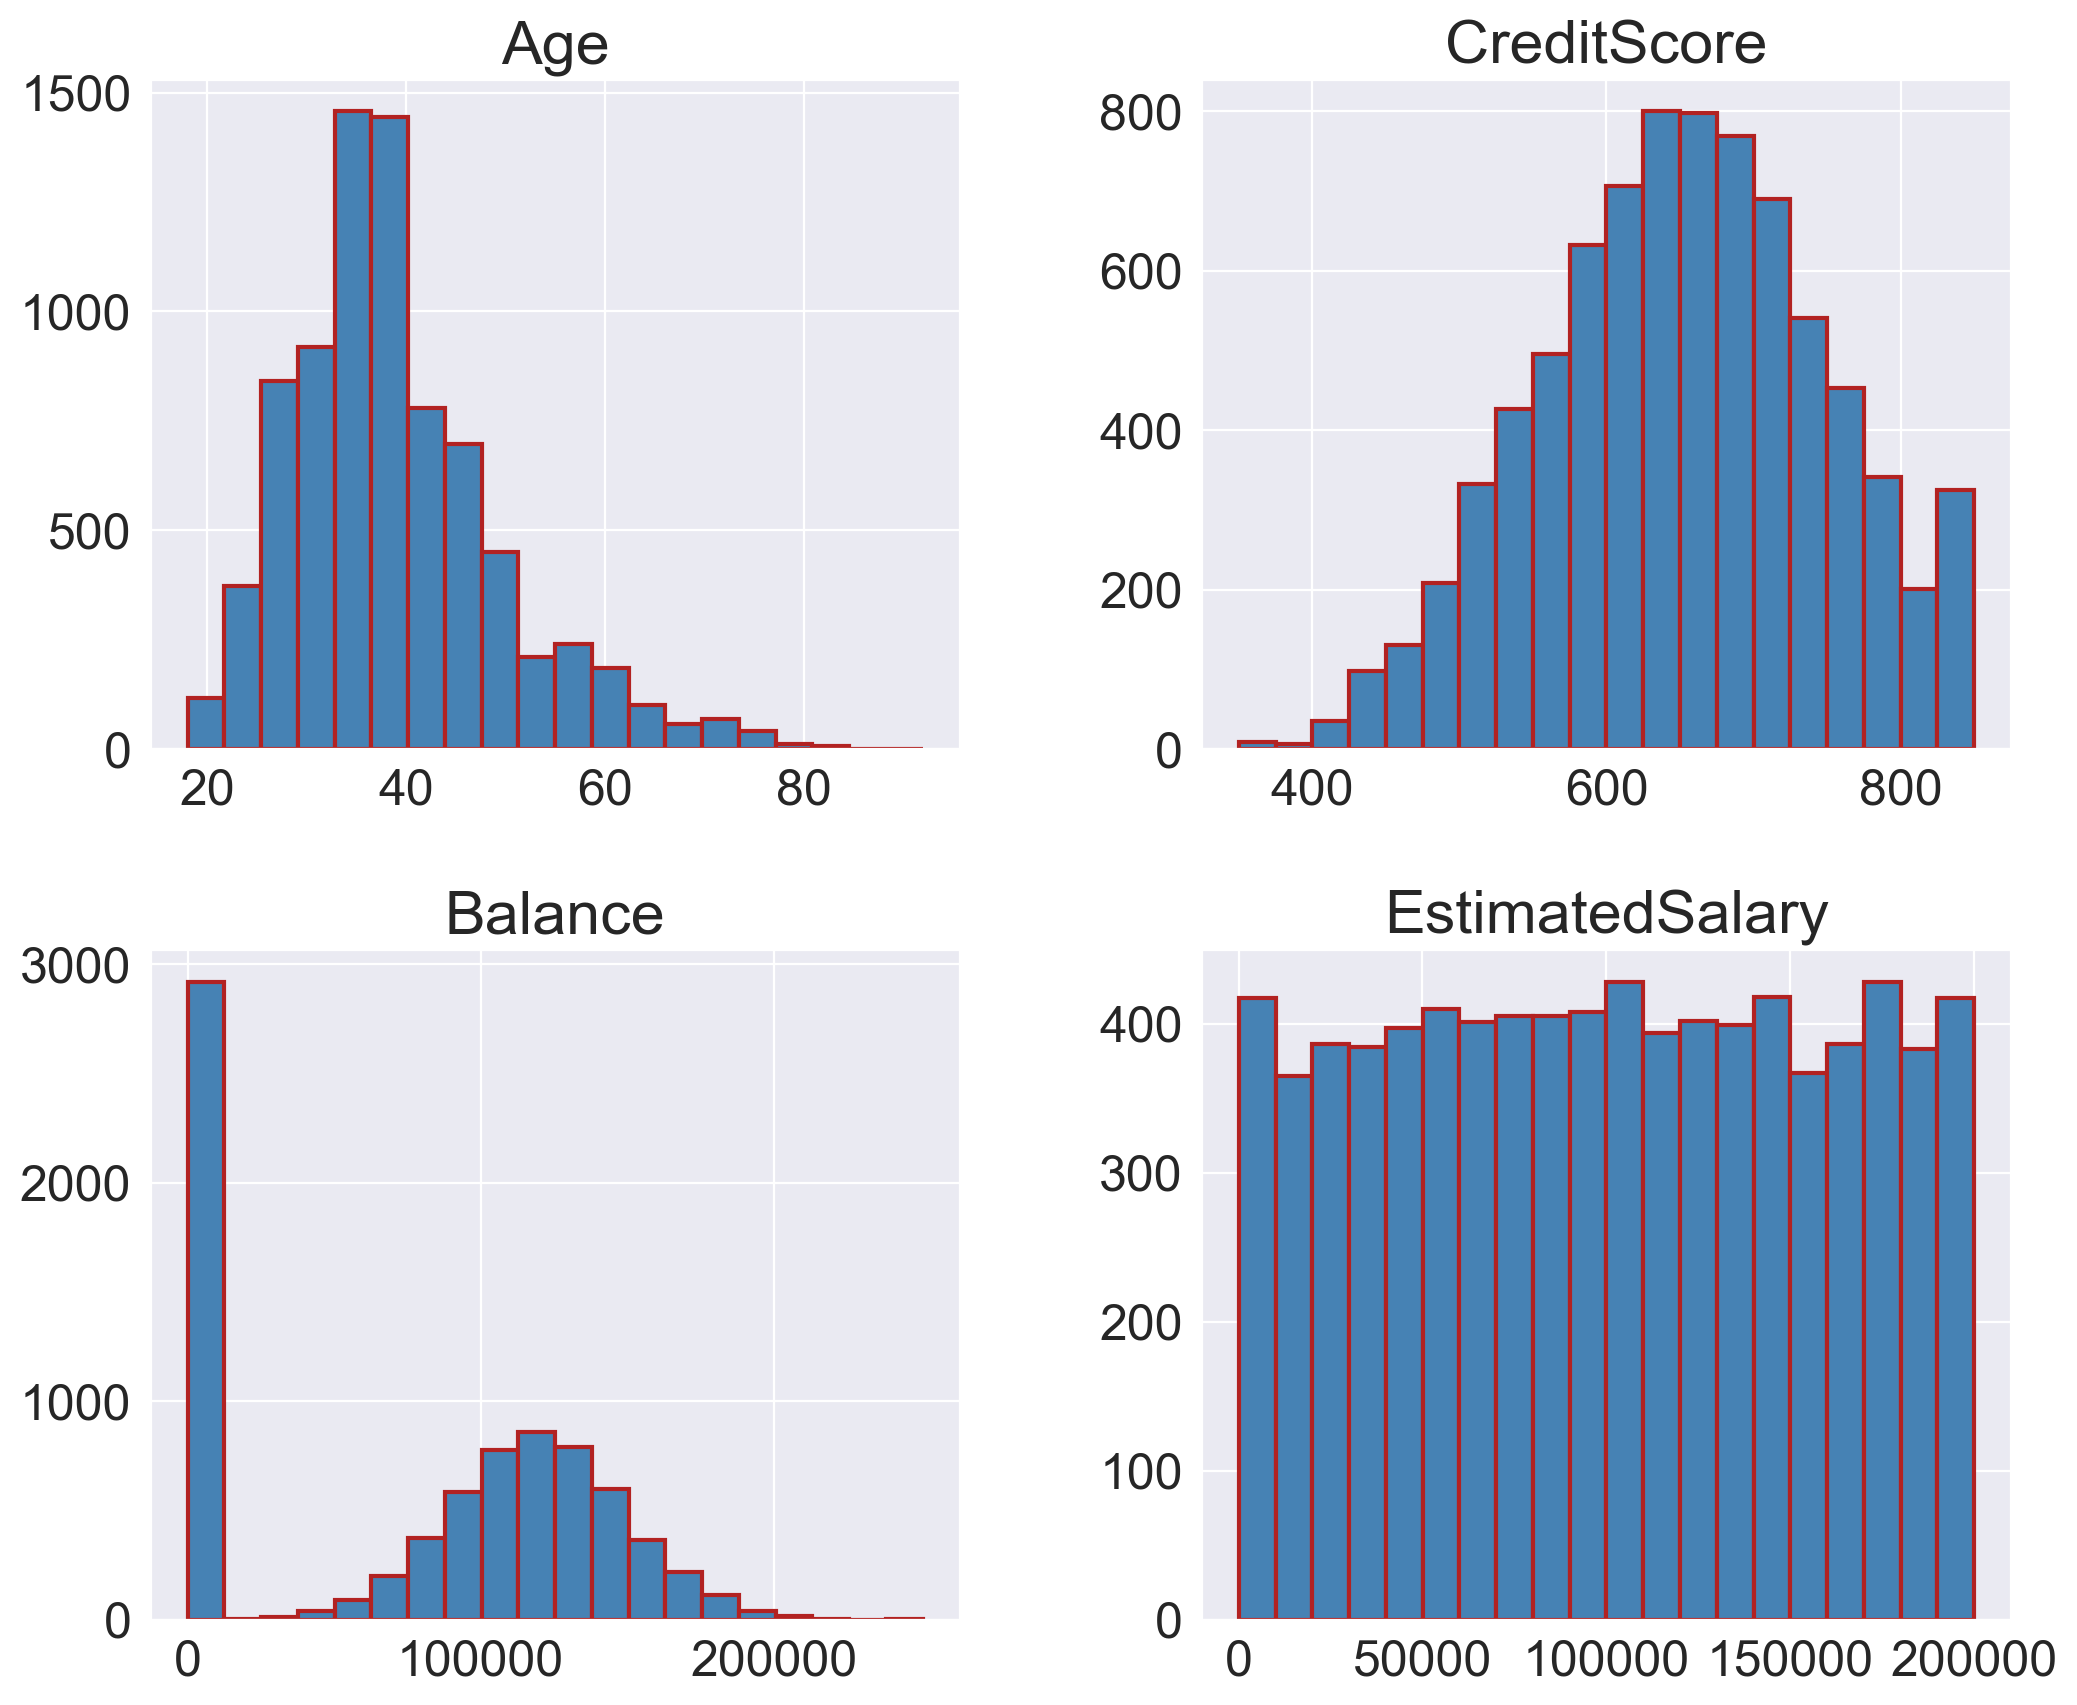

In [49]:
train_df[continuous].hist(figsize=(12, 10),
                          bins=20,
                          layout=(2, 2),
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);

- 'Age' is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left,
- Most values for 'CreditScore' are above 600,
- If we ignore the first bin, 'Balance' follows a fairly normal distribution, and
- The distribution of 'EstimatedSalary' is more or less uniform and provides little information.

## Looking for Correlations

We can compute the standard correlation coefficient between every pair of (continuous) features using the pandas' `corr()` method and plot it as a matrix:

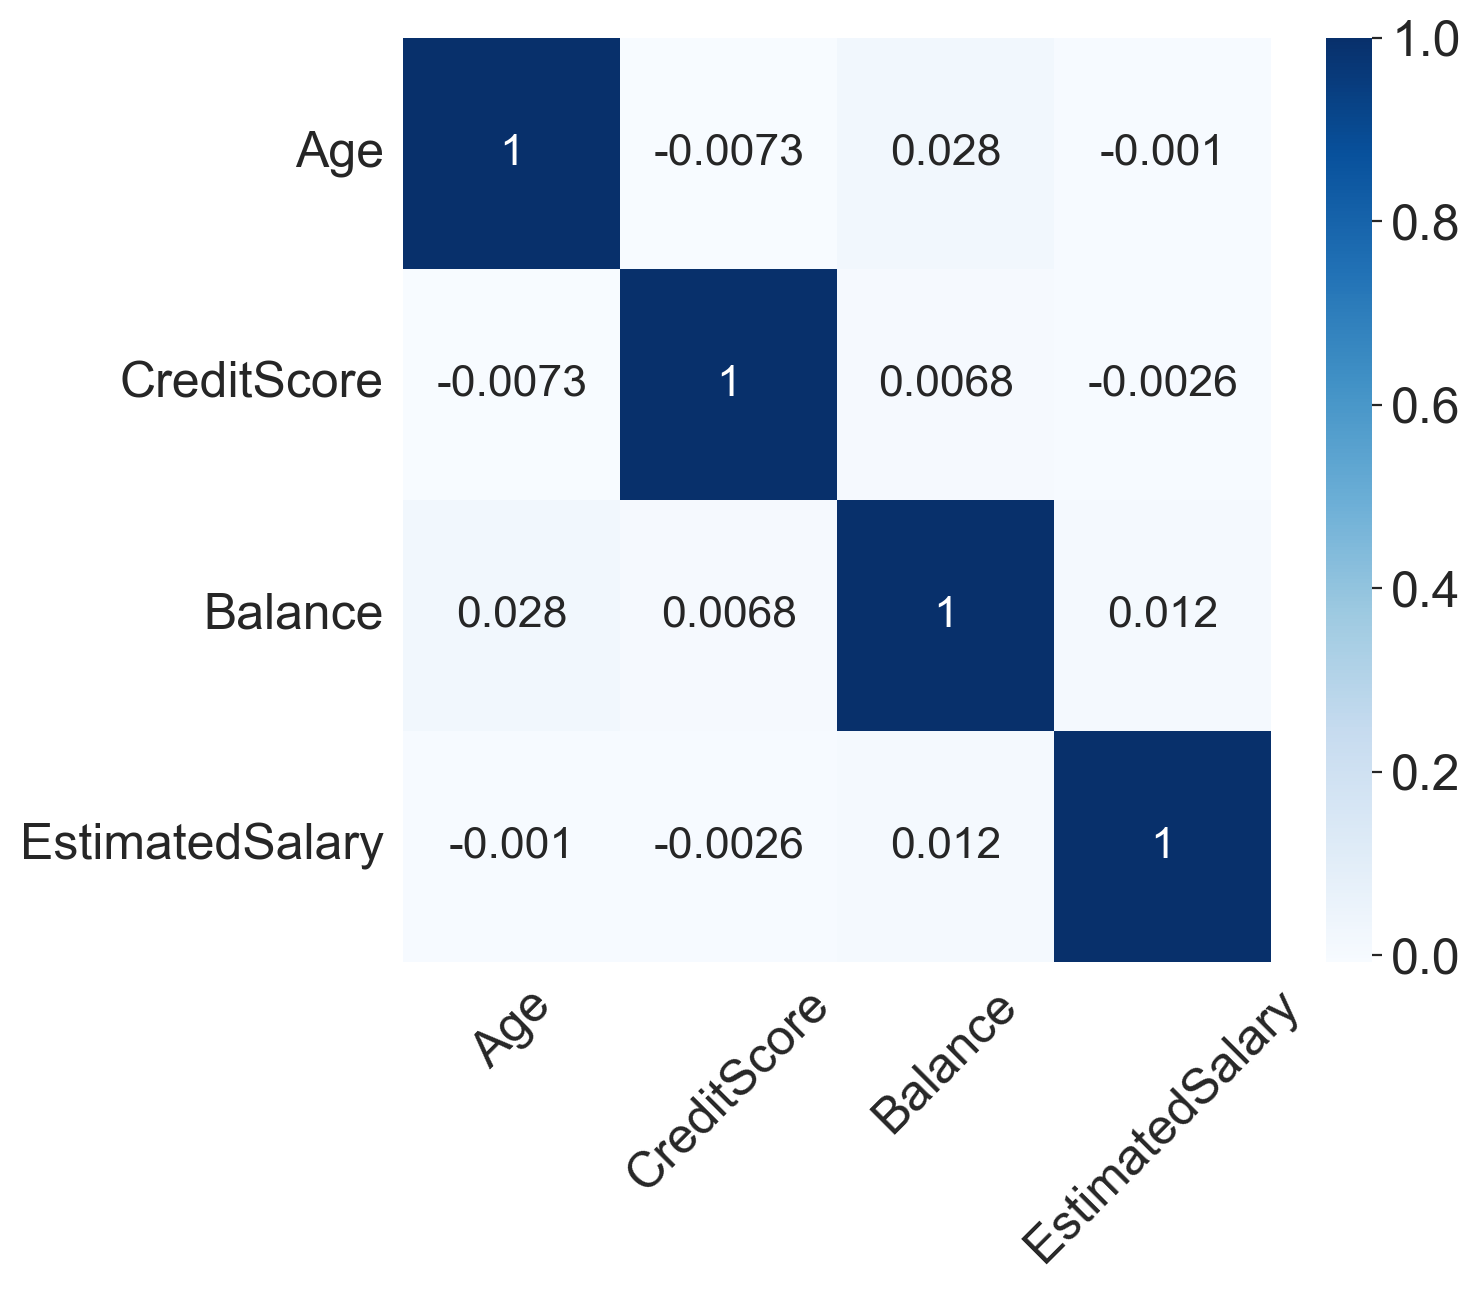

In [50]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(train_df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

There is no significant intercorrelation between our features, so we do **not** have to worry about multicollinearity.

Let's look at these features in greater detail.

### Age

/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2369535453.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['Retained', 'Churned'])


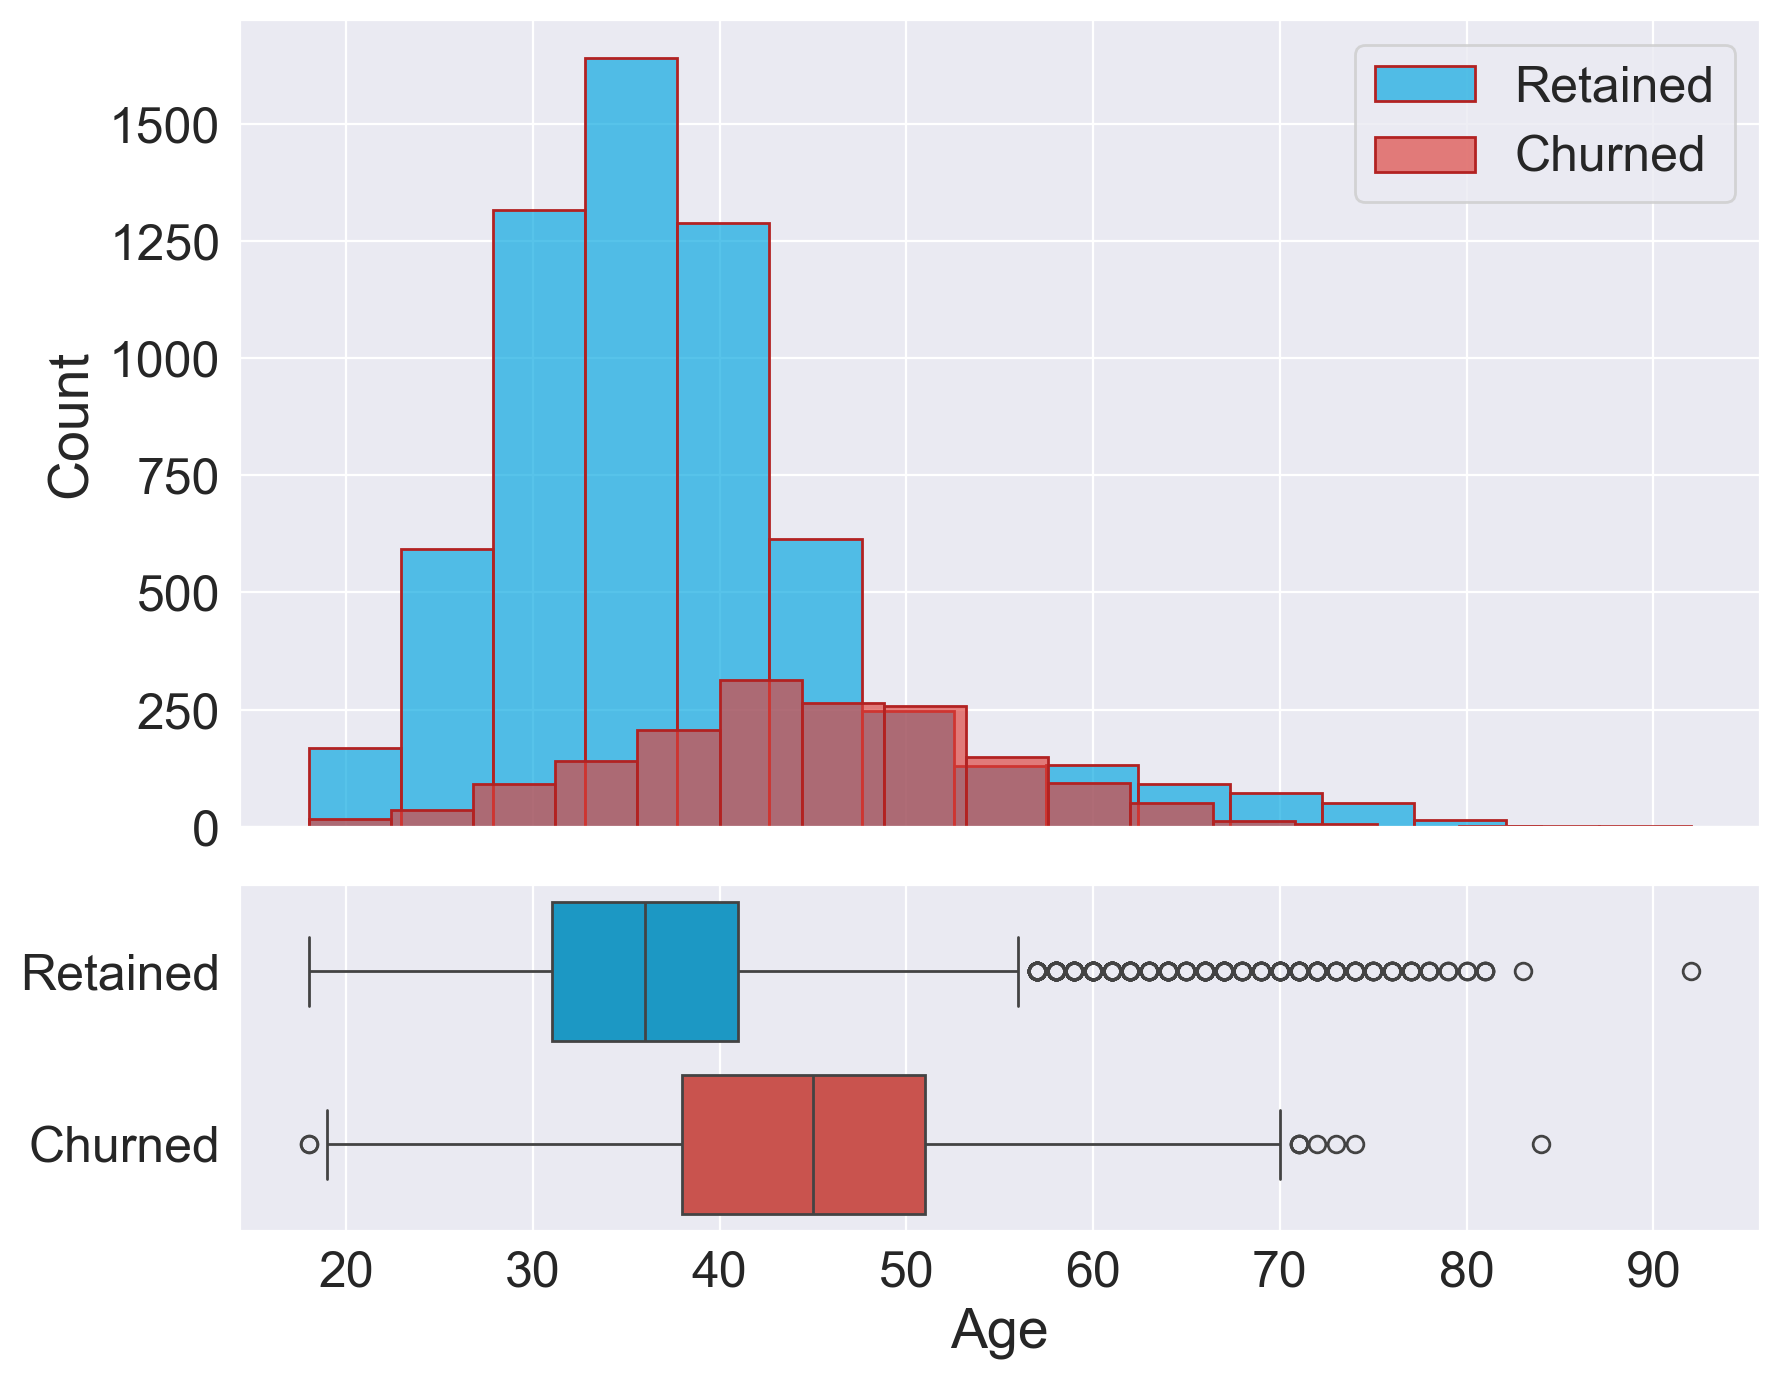

In [51]:
df_churned = train_df[train_df['Exited'] == 1]
df_retained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

Interestingly, there is a clear difference between age groups since older customers are more likely to churn. This observation could potentially indicate that preferences change with age, and the bank hasn't adapted its strategy to meet the requirements of older customers.

### Credit Score

/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2369535453.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['Retained', 'Churned'])


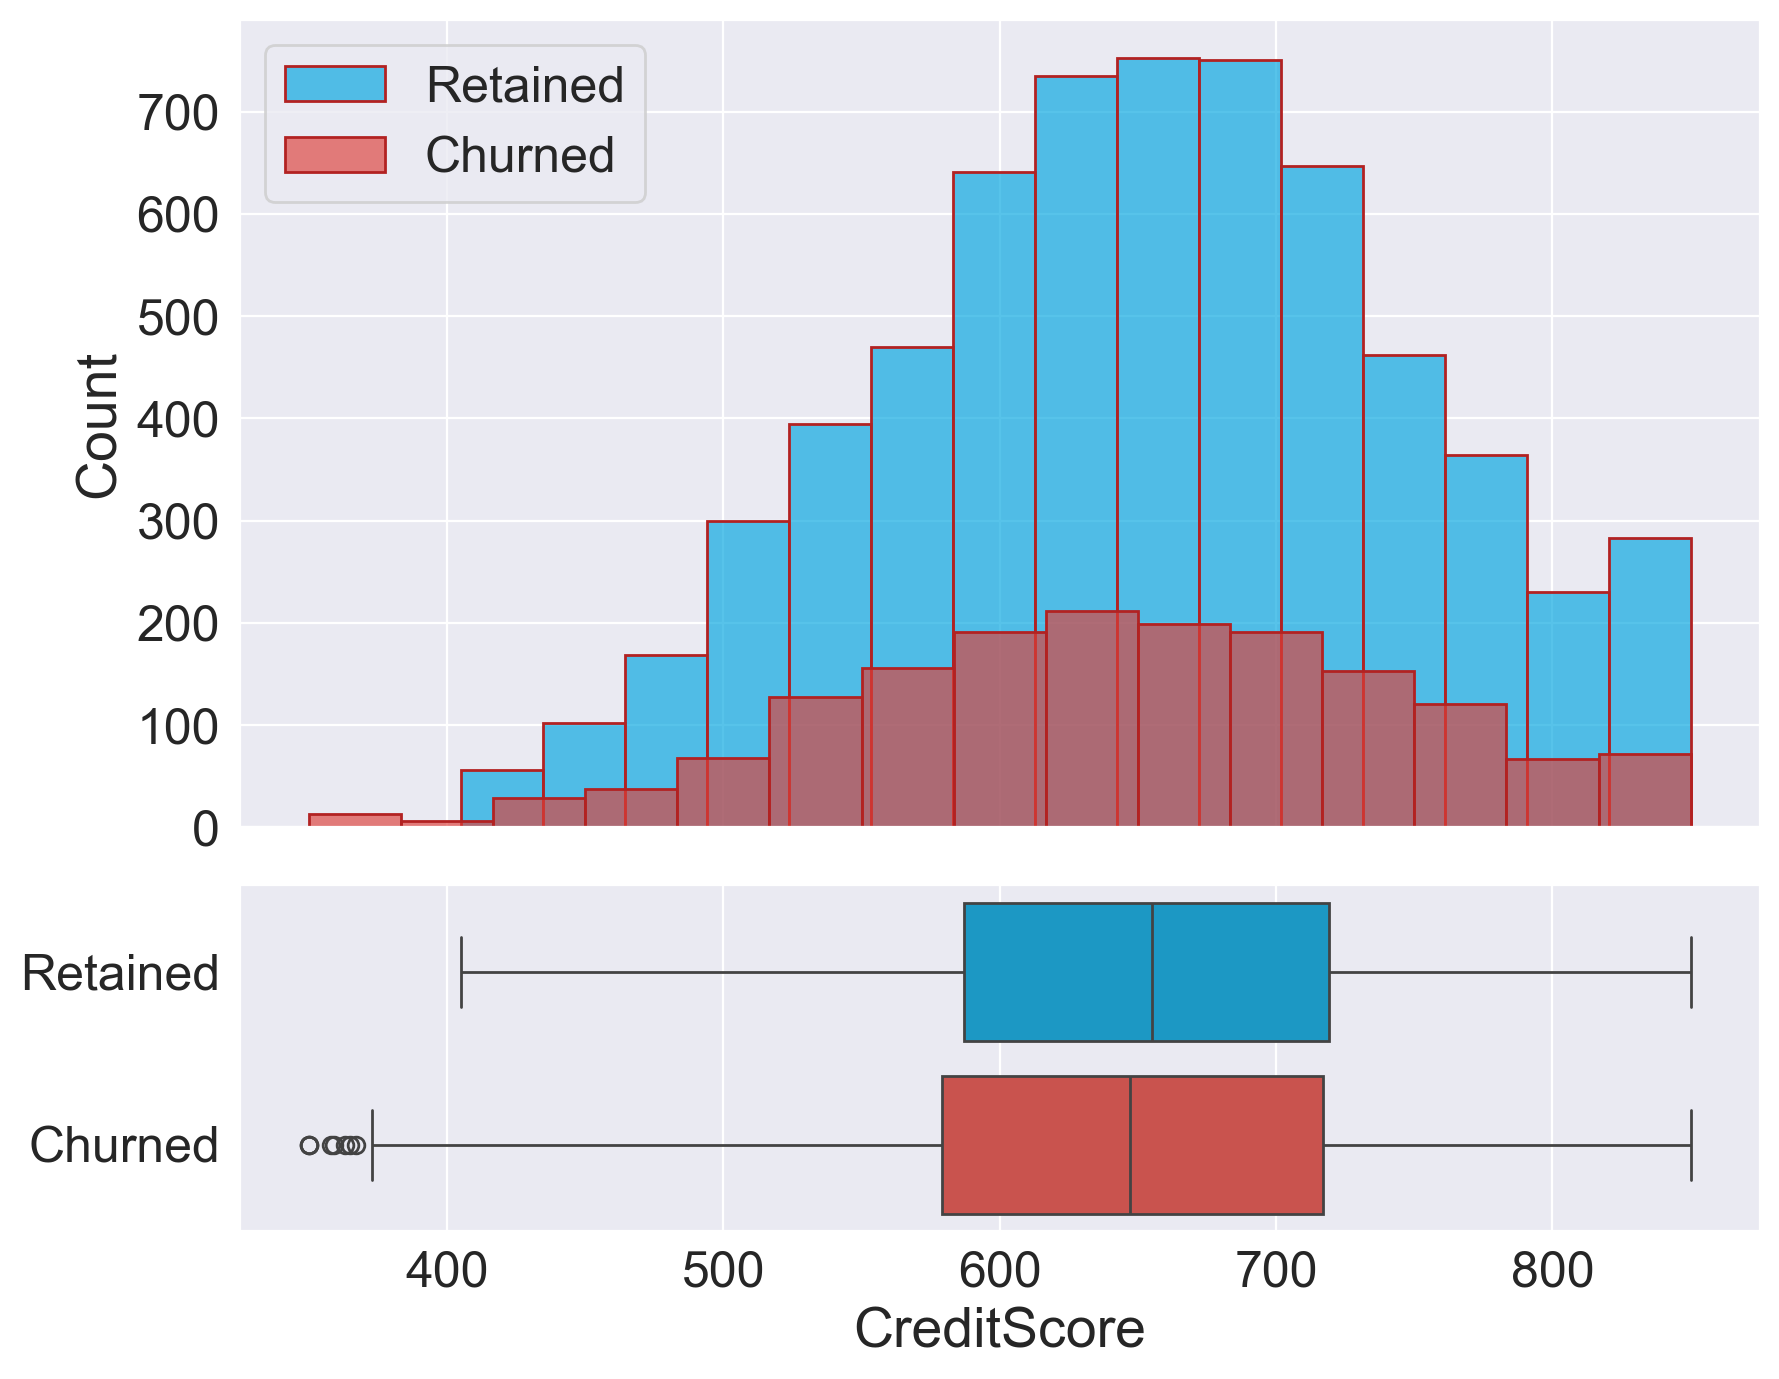

In [52]:
plot_continuous('CreditScore')

There is no significant difference between retained and churned customers in terms of their credit scores.

### Balance

/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2369535453.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['Retained', 'Churned'])


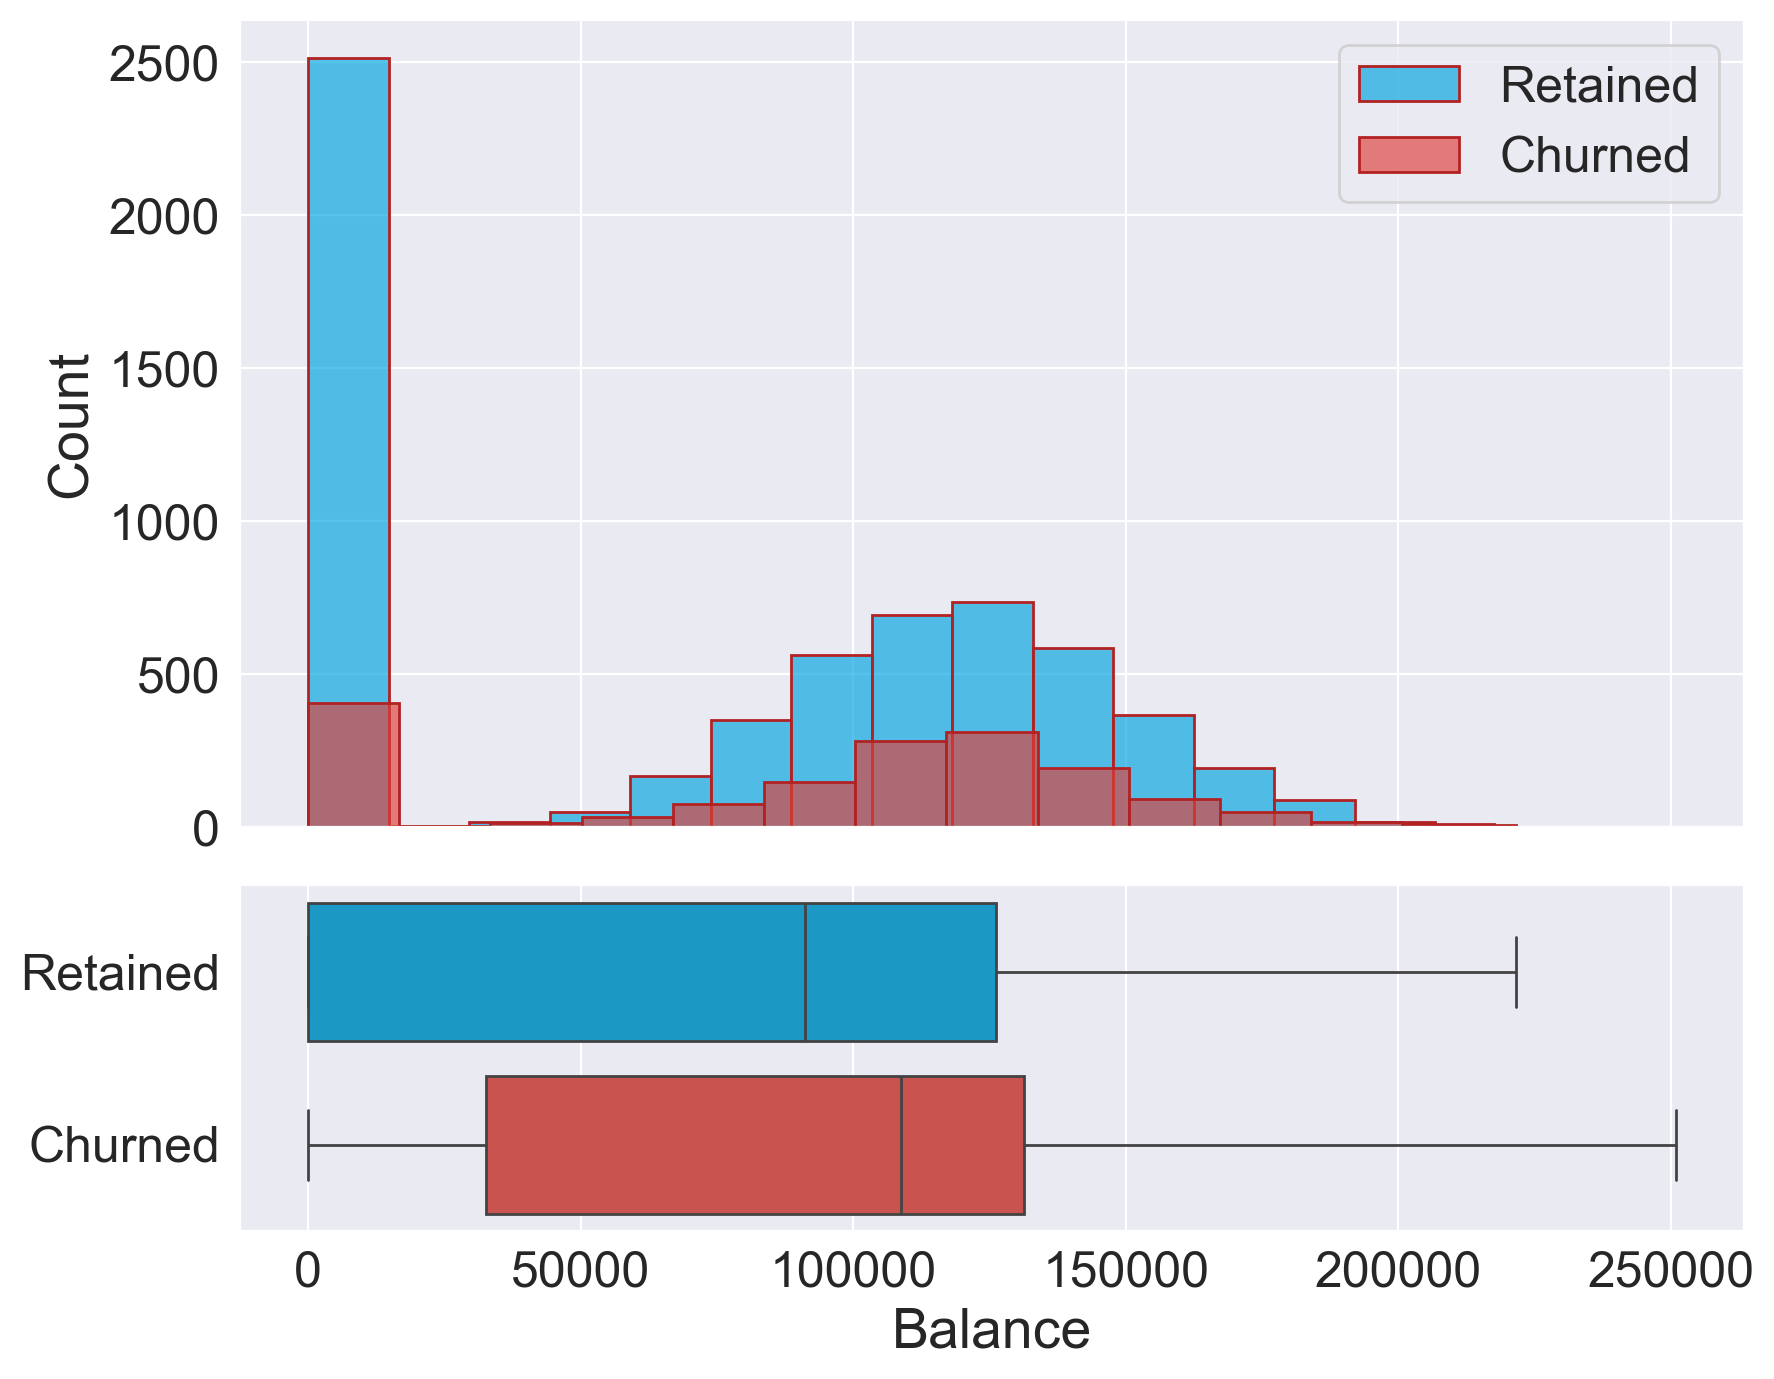

In [53]:
plot_continuous('Balance')

Again, the two distributions are quite similar. There is a big percentage of non-churned customers with a low account balance.

### Estimated Salary

/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2369535453.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['Retained', 'Churned'])


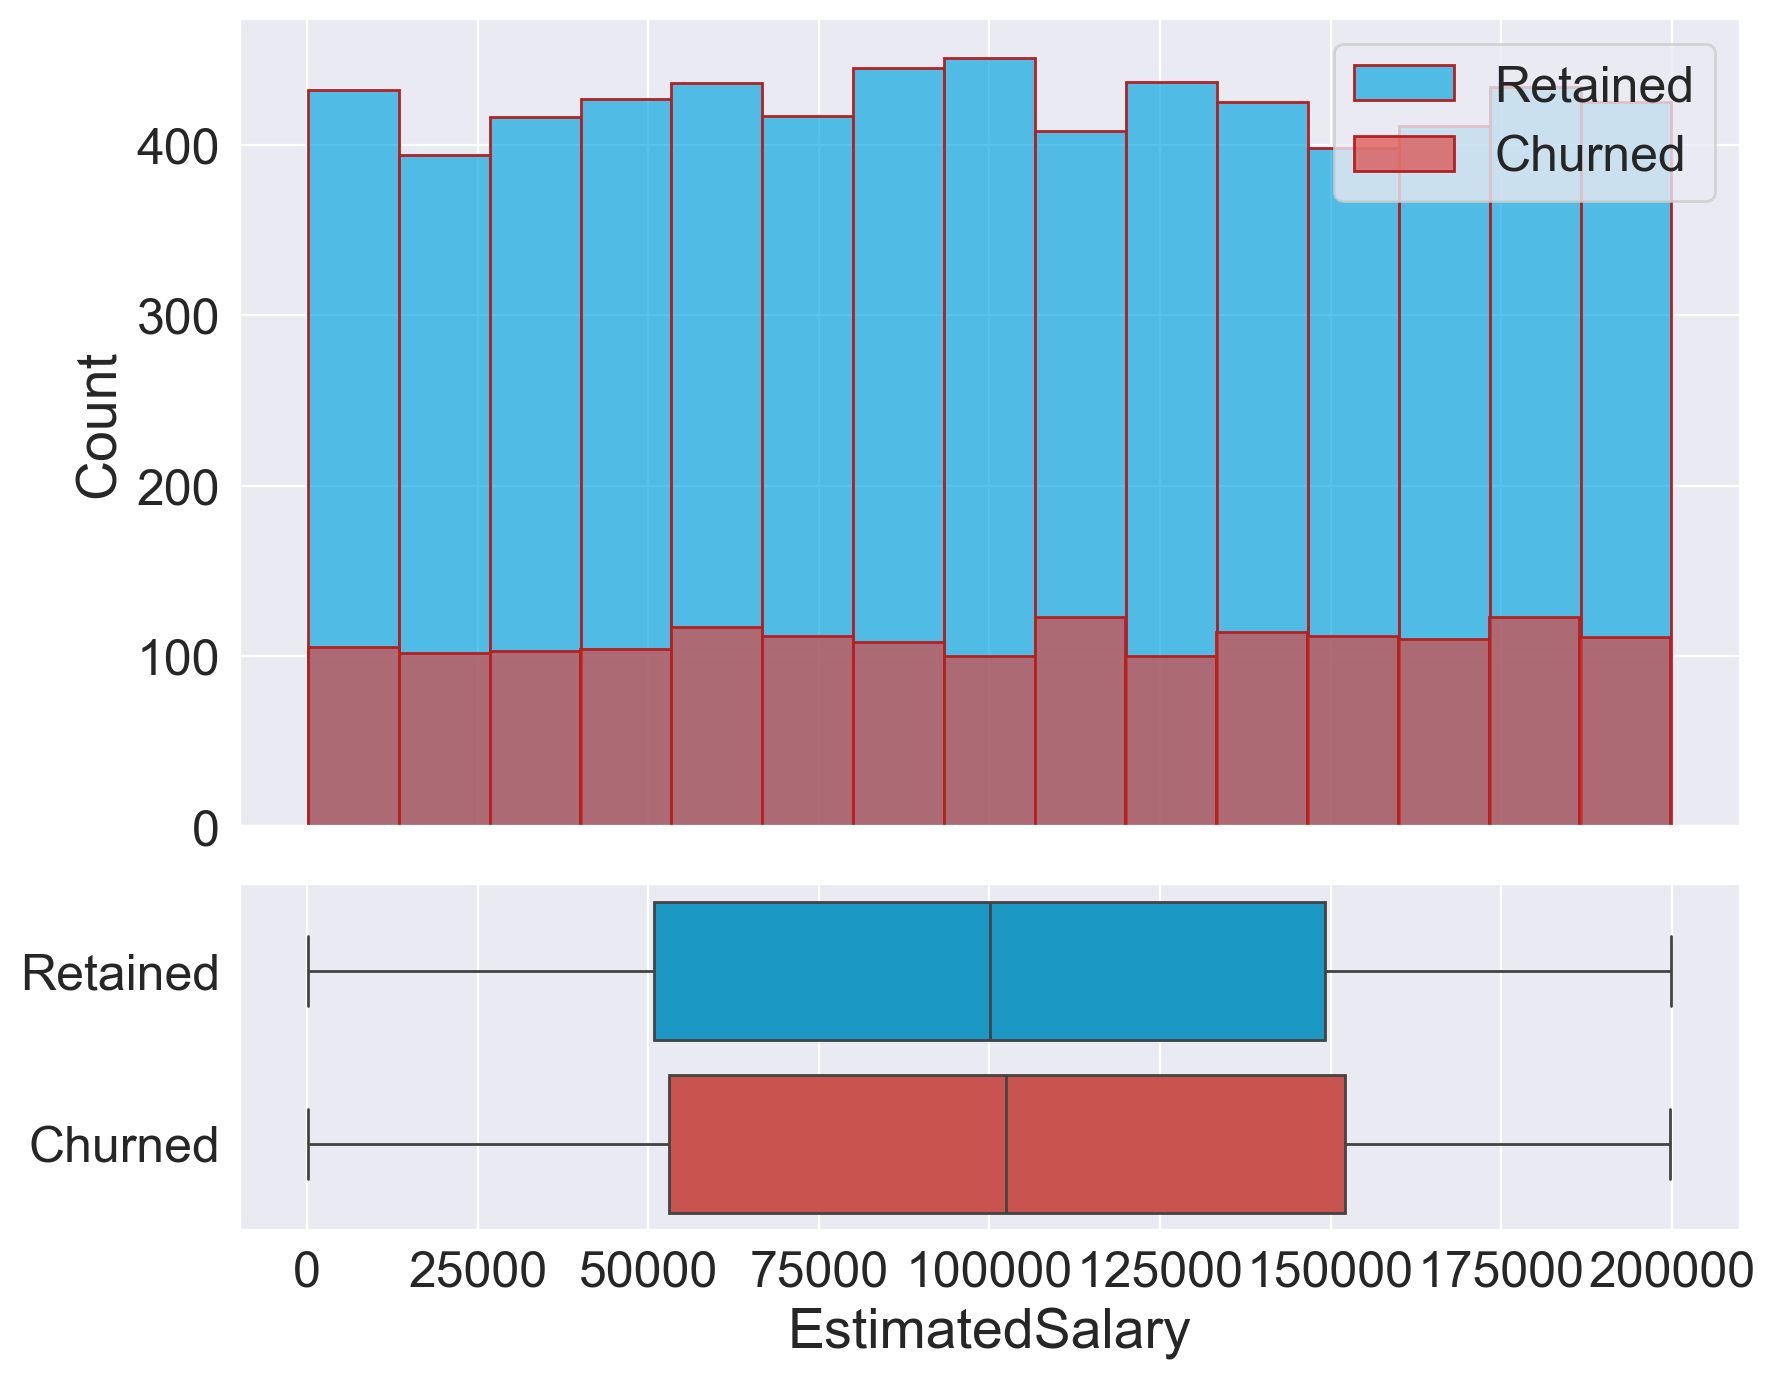

In [54]:
plot_continuous('EstimatedSalary')

Both churned and retained customers display a similar uniform distribution in their salaries. Consequently, we can conclude that salary doesn't have a significant effect on the likelihood to churn.

## Categorical Variables

Let's plot a seaborn.countplot for each categorical feature:

/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/4157164019.py:8: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/4157164019.py:8: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/4157164019.py:8: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/4157164019.py:8: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipy

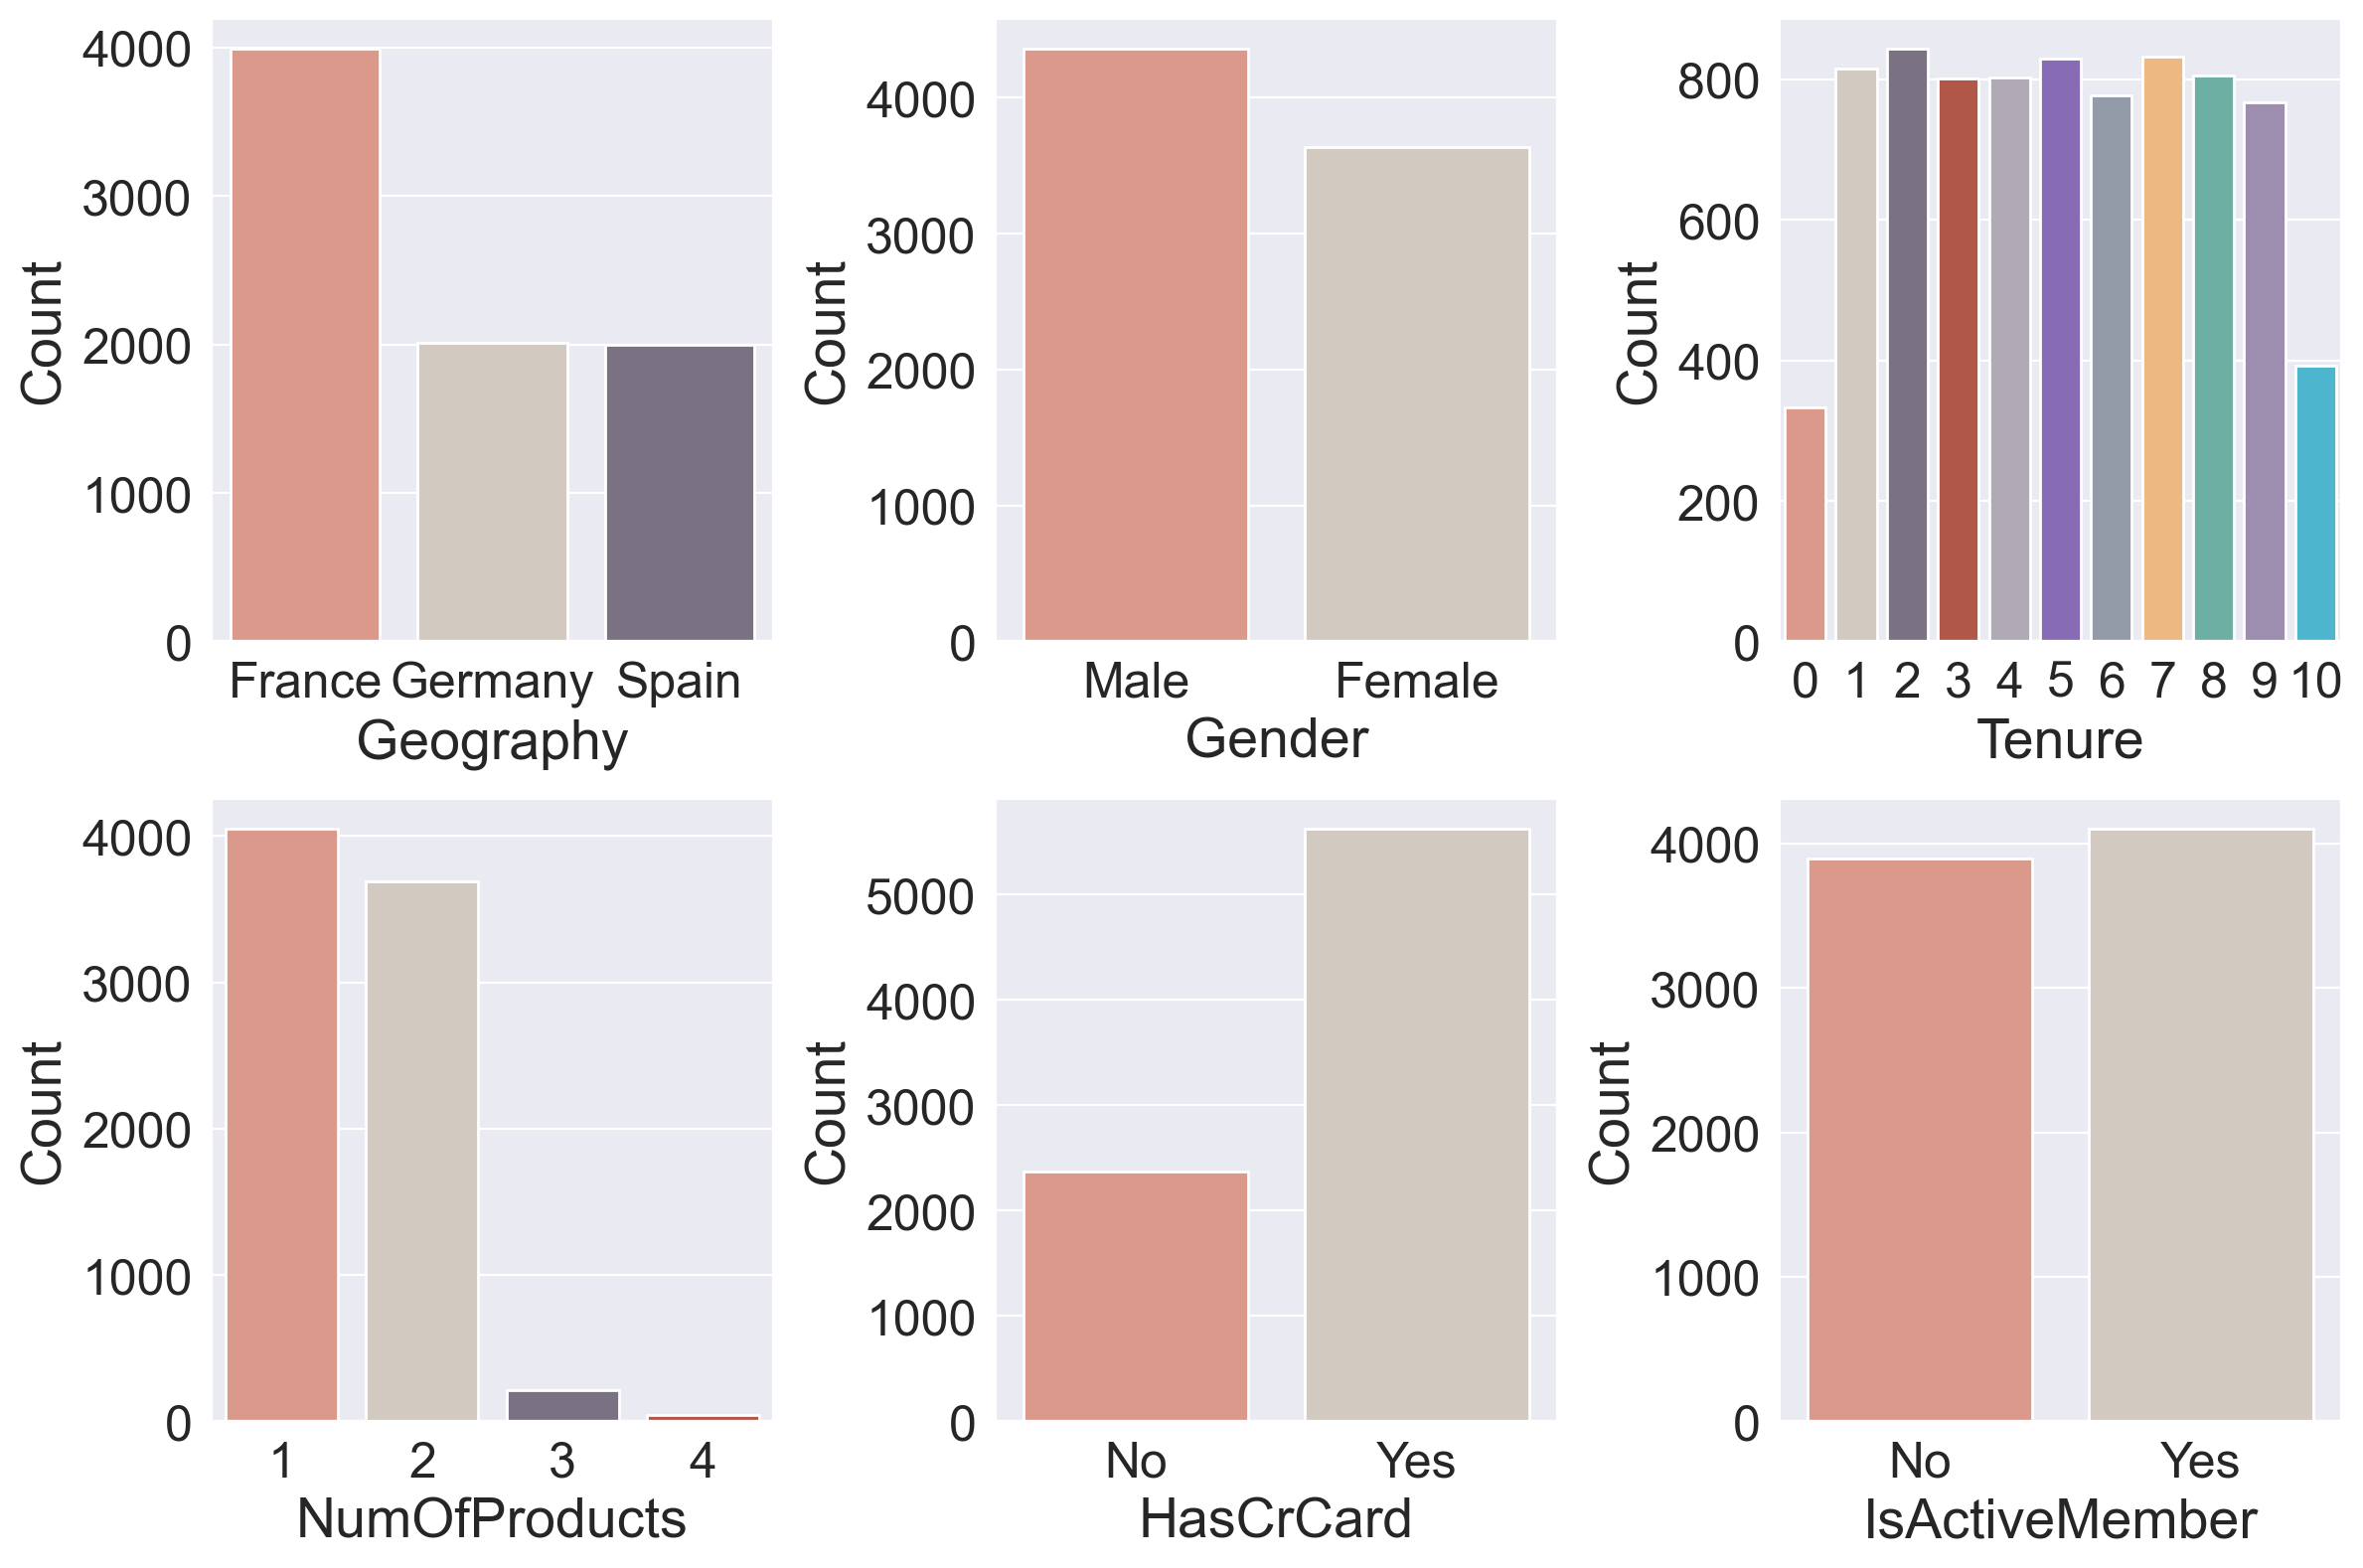

In [55]:
df_cat = train_df[categorical]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=train_df, palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

Important points:

- The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
- There are more male customers than females,
- Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,
- Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
- A significant majority of customers has a credit card, and
- Almost 50% of customers are not active.

Again, we will look at these features in greater detail.

### Geography

/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2034032756.py:13: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  sns.barplot(x=feature,


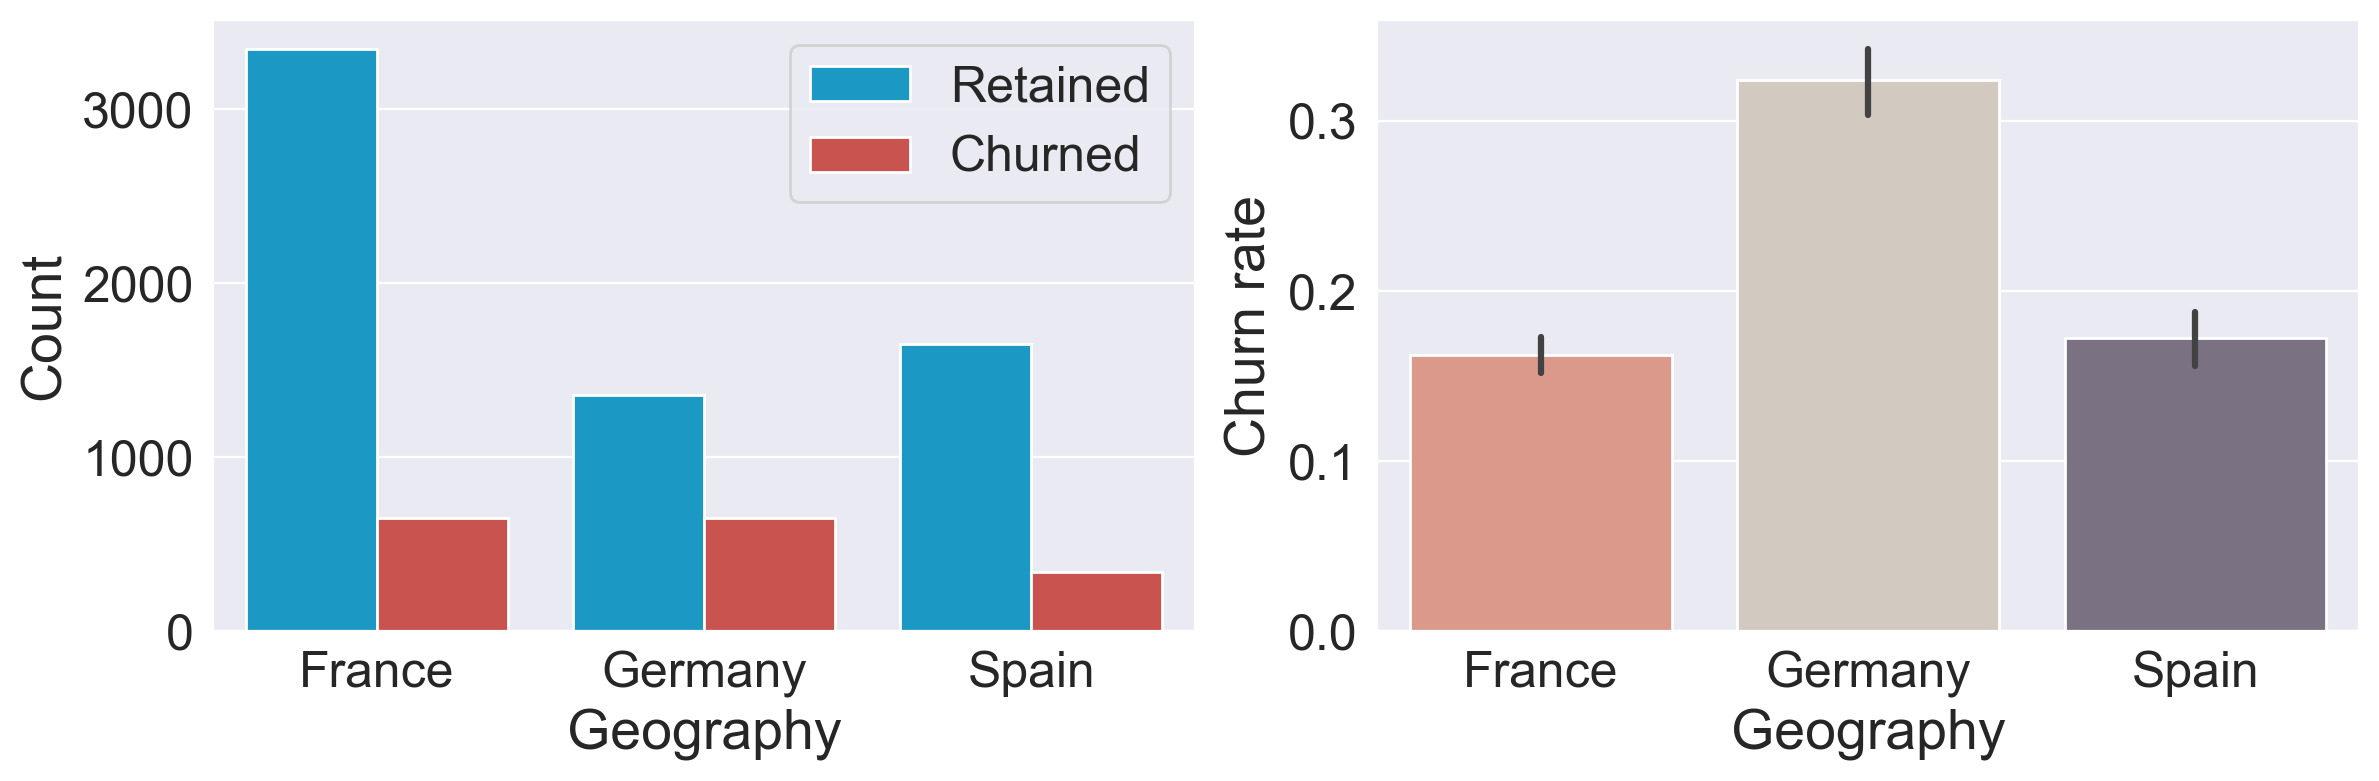

In [56]:
plot_categorical('Geography')

Customers in Germany are more likely to churn than customers in the other two countries (the churn rate is almost double compared to Spain and France). Many reasons could explain this finding, such as higher competition or different preferences for German customers.

### Gender

/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2034032756.py:13: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.barplot(x=feature,


Error in callback <function _draw_all_if_interactive at 0x11966cea0> (for post_execute):


KeyboardInterrupt: 

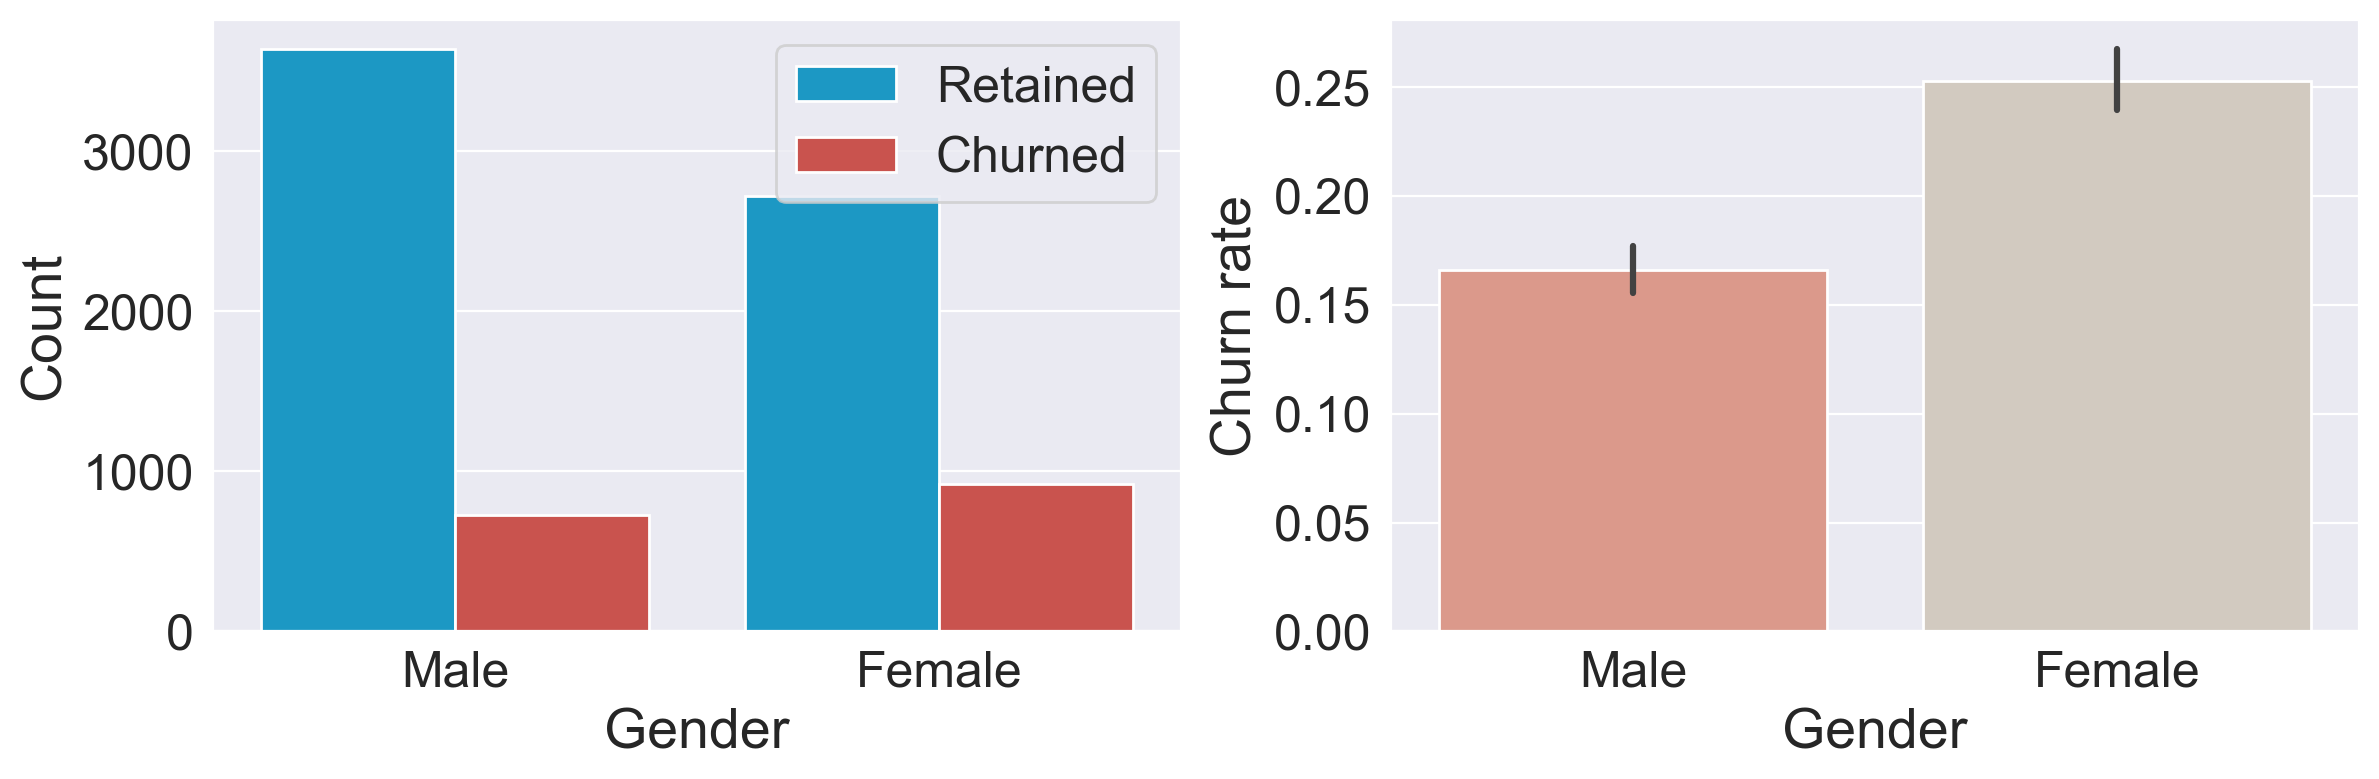

In [57]:
plot_categorical('Gender')

Female customers are more likely to churn.

### Tenure

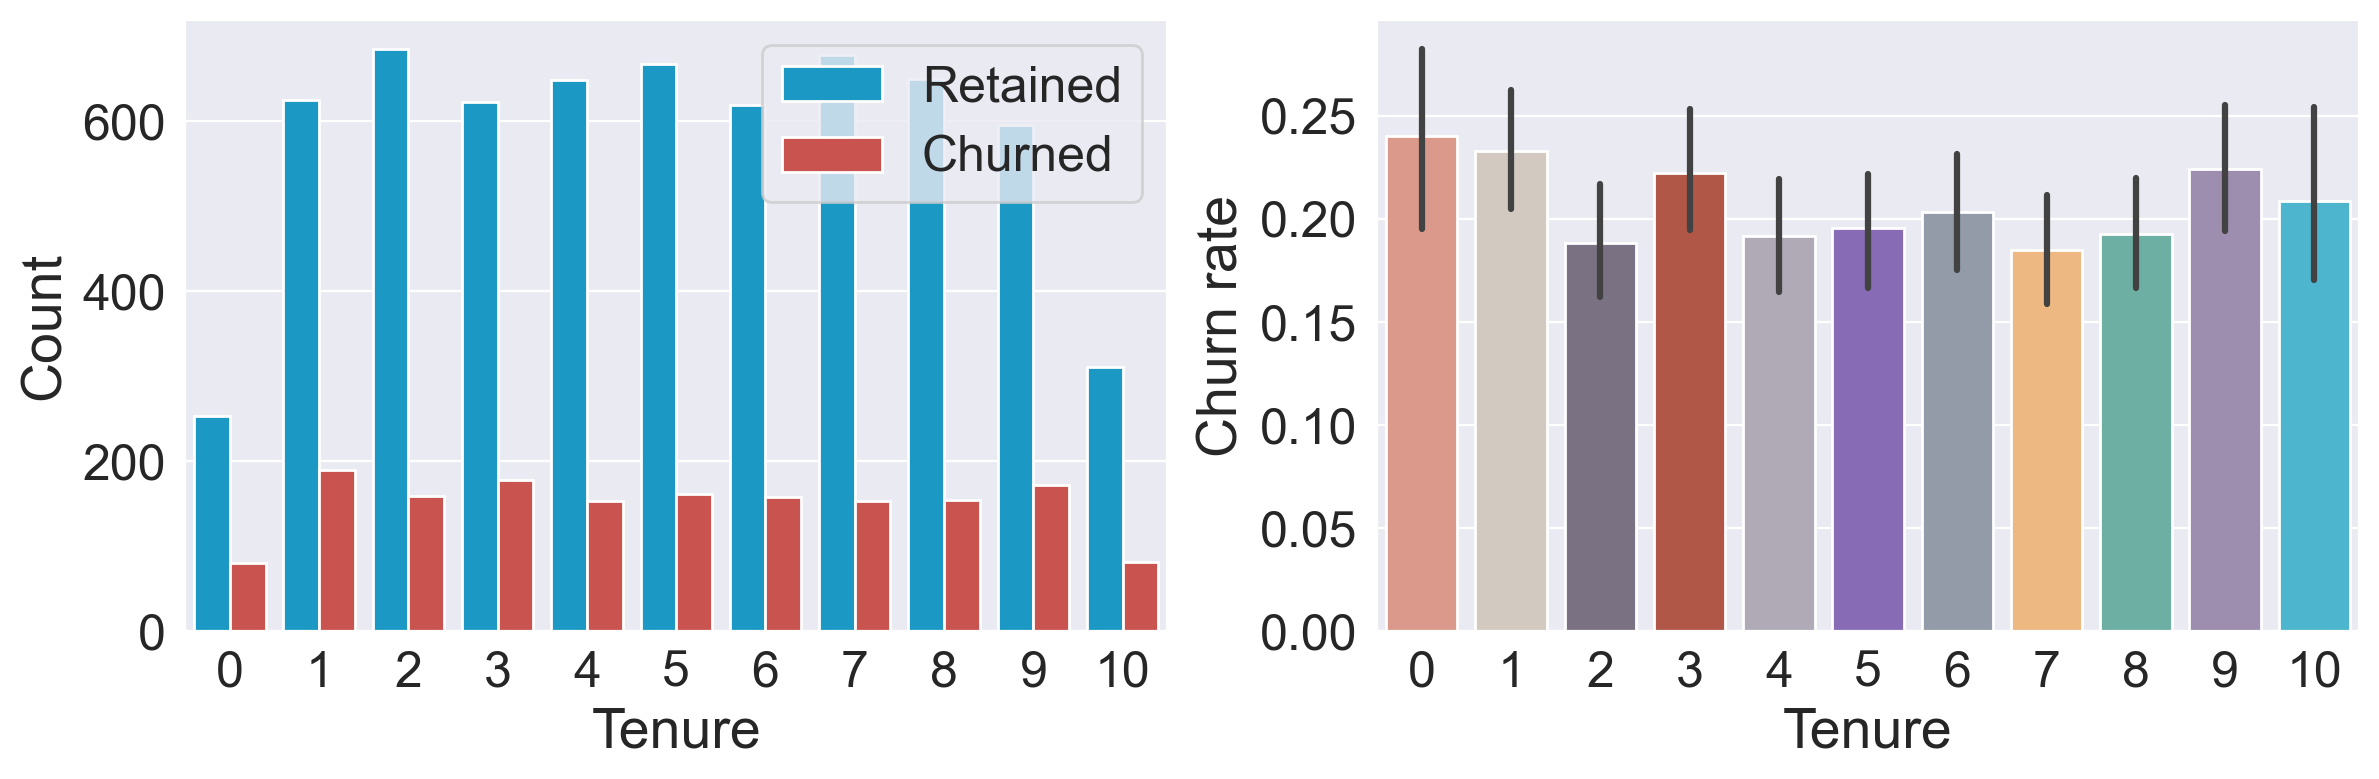

In [ ]:
plot_categorical('Tenure')

The number of years (tenure) does not seem to affect the churn rate.

### Number of Products

/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2034032756.py:13: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns.barplot(x=feature,


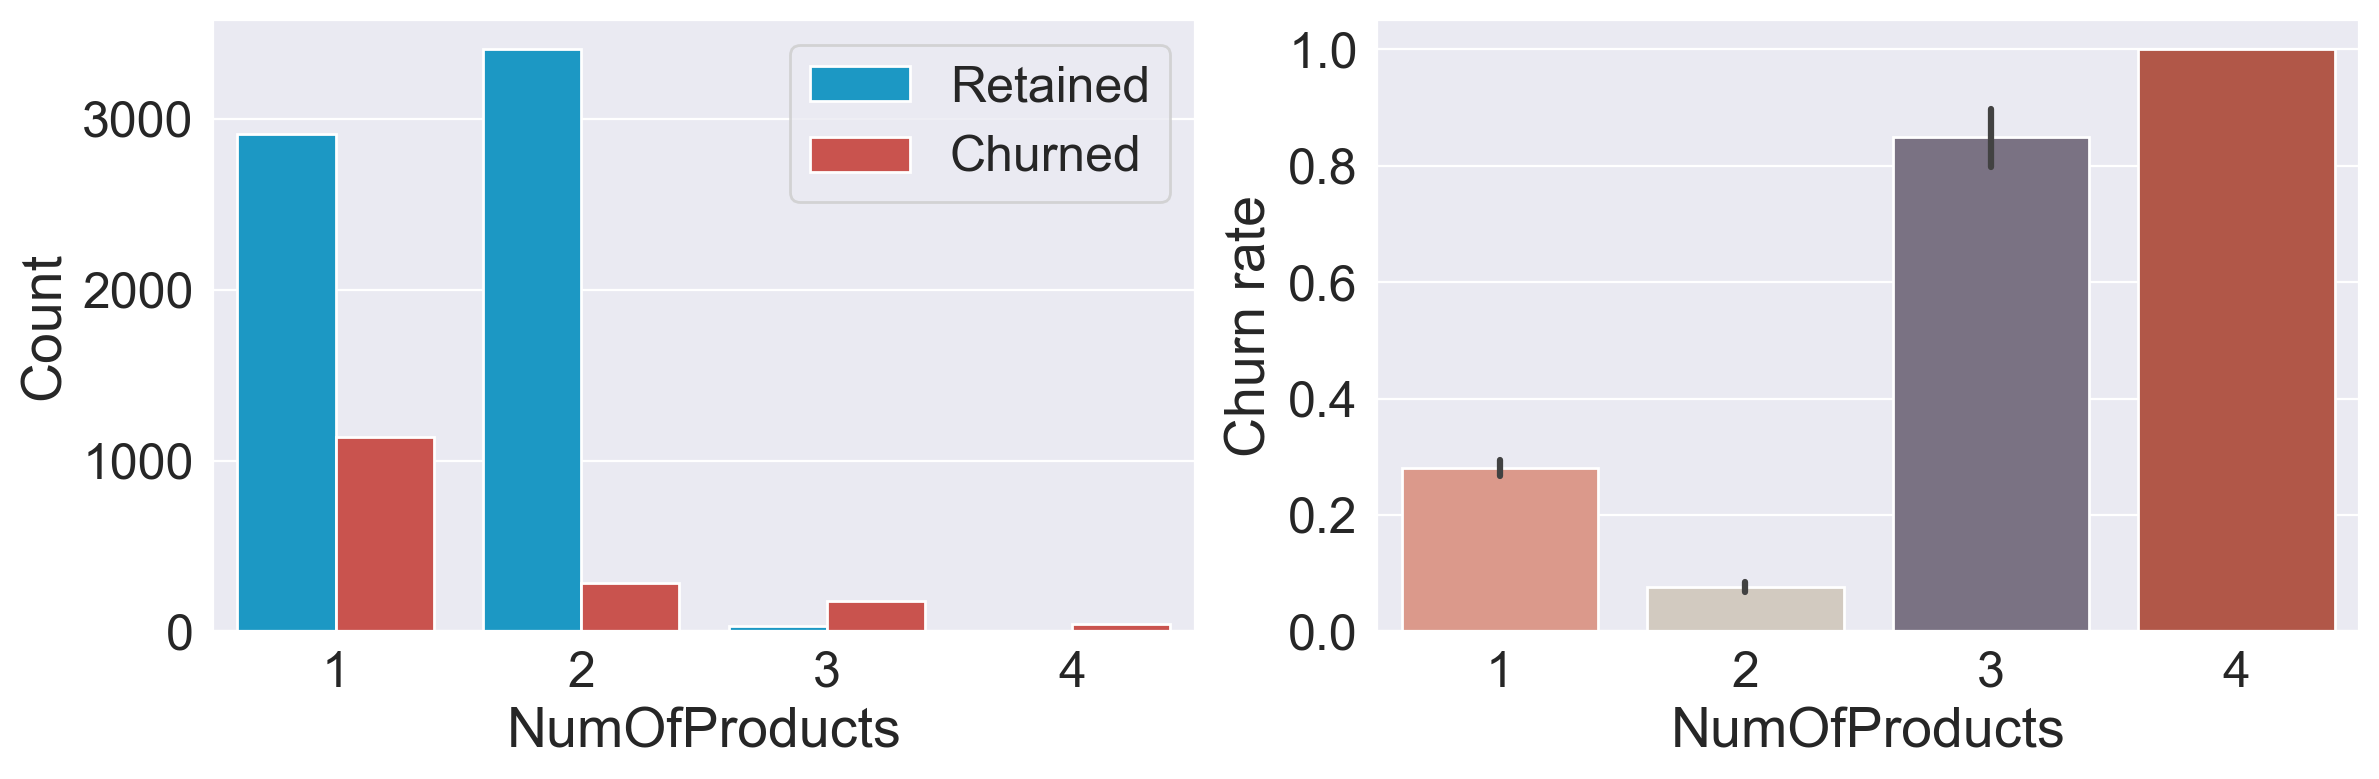

In [ ]:
plot_categorical('NumOfProducts')

Interestingly, having 3 or 4 products significantly increases the likelihood of churn. I am not sure how to interpret this result. It could potentially mean that the bank cannot properly support customers with more products which in turn increases customer dissatisfaction.

### Card Holders

/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2034032756.py:13: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.barplot(x=feature,
/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2034032756.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['No', 'Yes'])
/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2034032756.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['No', 'Yes'])


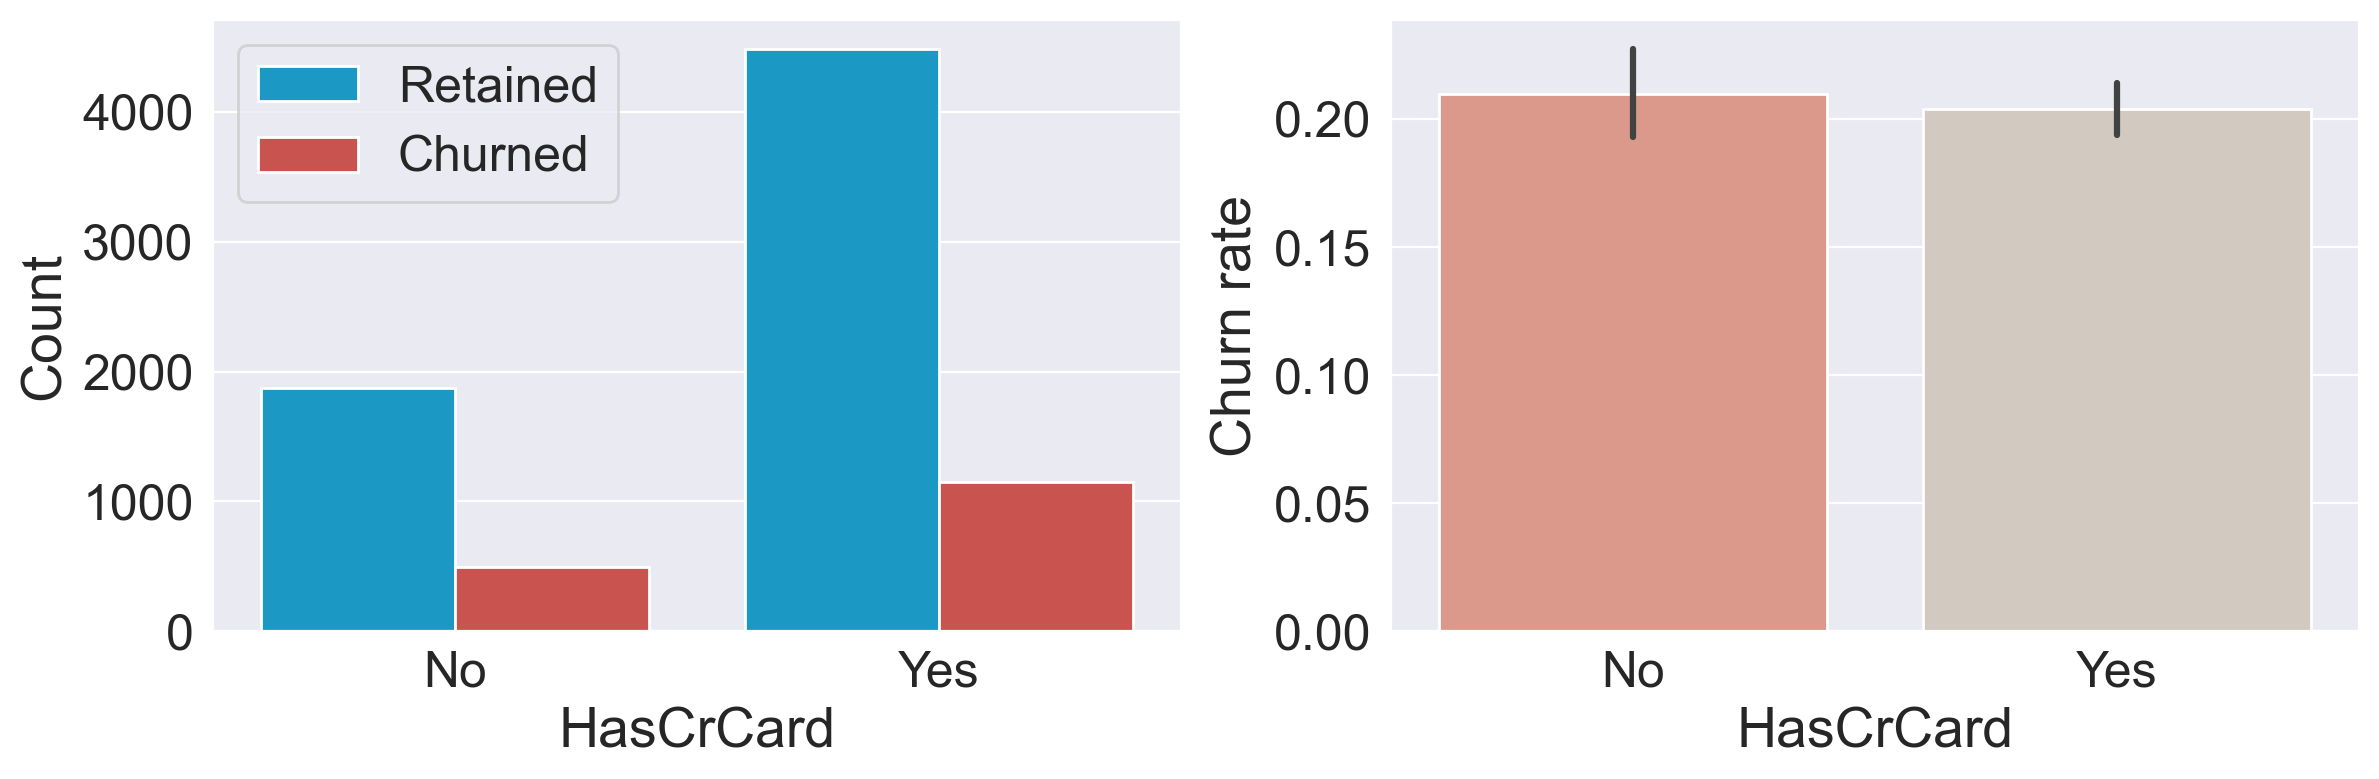

In [ ]:
plot_categorical('HasCrCard')

Having a credit card does not seem to affect the churn rate.

### Active Members

/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2034032756.py:13: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.barplot(x=feature,
/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2034032756.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['No', 'Yes'])
/var/folders/b9/rpbdtb191bd5fhsqy8l2j8g00000gp/T/ipykernel_8375/2034032756.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['No', 'Yes'])


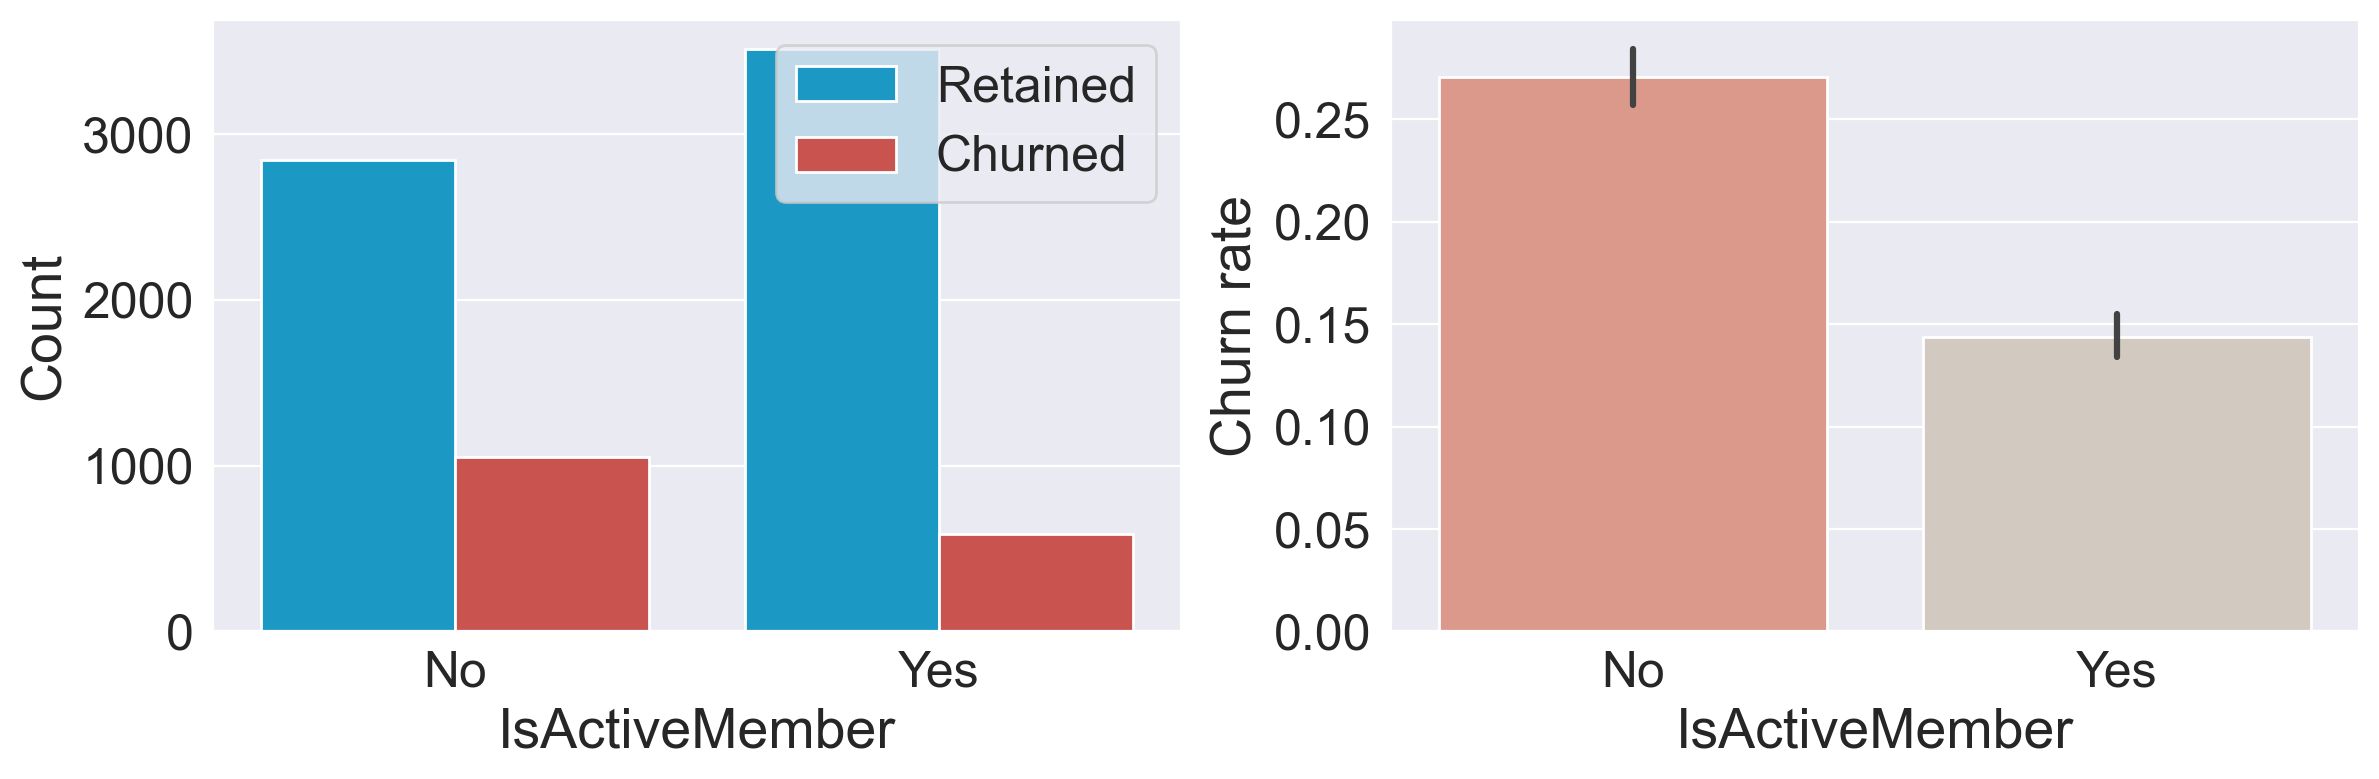

In [ ]:
plot_categorical('IsActiveMember')

It's not a surprise that inactive customers are more likely to churn. A significant portion of the clientele is inactive; therefore, the bank will benefit from changing its policy so that more customers become active.

<br>

# Data Preprocessing

Data preprocessing is the process of converting raw data into a well-readable format that is suitable for building and training Machine Learning models.

Let's complete this process step-by-step.

## Feature Selection

We have already performed feature selection by dropping columns 'RowNumber', 'CustomerId', and 'Surname' at the beginning of our notebook. EDA revealed several more features that can be dropped as they do not provide any value in predicting our target variable:

- 'EstimatedSalary' displays a uniform distribution for both types of customers and can be dropped.
- The categories in 'Tenure' and 'HasCrCard' have a similar churn rate and are deemed redundant. This can be confirmed from a chi-square test [[2](#Bibliography)]:

In [ ]:
chi2_array, p_array = [], []
for column in categorical:

    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable': categorical,
    'Chi-square': chi2_array,
    'p-value': p_array
})
df_chi.sort_values(by='Chi-square', ascending=False)

,Variable,Chi-square,p-value
3,NumOfProducts,1233.595482,3.767234e-267
0,Geography,230.747892,7.829463e-51
5,IsActiveMember,195.314895,2.199308e-44
1,Gender,90.172536,2.182709e-21
2,Tenure,15.196853,1.250481e-01
4,HasCrCard,0.300882,5.833299e-01


'Tenure' and 'HasCrCard' have a small chi-square and a p-value greater than 0.05 (the standard cut-off value), confirming our initial hypothesis that these two features do not convey any useful information.

We can use the `drop()` method to remove these three features from the train set:

In [ ]:
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(features_drop, axis=1)

print('✔️ Features Dropped!')

✔️ Features Dropped!


## Encoding Categorical Features

Machine learning algorithms usually require that all input (and output) features are numeric. Consequently, categorical features need to be converted (encoded) to numbers before building models.

Our dataset contains two features that require encoding.

- For 'Gender', we will use scikit-learn's `LabelEncoder()` which maps each unique label to an integer (Male --> 1 and Female --> 0).
- For 'Geography', we will manually map values so that customers in Germany have the value of one (1) and all other customers (France and Spain) have zero (0). I chose this method since the churn rate for customers in the other two countries is almost equal and considerably lower than in Germany. Therefore, it makes sense to encode this feature so that it differentiates between German and non-German customers. Additionally, I tried one-hot encoding (`get_dummies()`) this feature, and the two new features for France and Spain had small feature importance.


In [ ]:
train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

print('✔️ Features Encoded!')

✔️ Features Encoded!


## Scaling

Feature scaling is a technique used to normalise the range of features in a dataset. Some algorithms are sensitive to feature scaling (e.g. SVMs), while others are invariant (e.g. Random Forests). 

I decided to use `StandardScaler()`, which standardises features by subtracting the mean and dividing by the standard deviation. This transformation results in features with zero mean and unit variance.

In [ ]:
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

print('✔️ Features Scaled!')

✔️ Features Scaled!


Finally, we will split the train set into 'X_train' and 'y_train' sets:

In [ ]:
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

print('✔️ Sets Created!')

TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

## Addressing Class Imbalance

As we have seen previously, there is an imbalance in the classes to be predicted, with one class (0 – retained) much more prevalent than the other (1 - churned):

In [ ]:
y_train.value_counts()

0    6356
1    1644
Name: Exited, dtype: int64

Class imbalance is usually a problem and occurs in many real-world tasks. Classification using imbalanced data is biased in favour of the majority class, meaning that machine learning algorithms will likely result in models that do little more than predict the most common class. Additionally, common metrics can be misleading when handling class-imbalanced data (e.g. if a dataset contains 99.9% 0s and 0.01% 1s, a classifier that always predicts 0 will have 99.9% accuracy).

Thankfully, some strategies can address this problem. I decided to use the SMOTE ('Synthetic Minority Oversampling Technique') algorithm, which, as we read in [[2](#Bibliography)], <br>
'*finds a record that is similar to the record being upsampled and creates a synthetic record that is a randomly weighted average of the original record and the neighbouring record, where the weight is generated separately for each predictor*'.

I’ll use the `SMOTE` function from [imblearn](https://imbalanced-learn.readthedocs.io/en/stable/api.html) with the `sampling_strategy` set to 'auto'.

In [ ]:
over = SMOTE(sampling_strategy='auto', random_state=random_state)
X_train, y_train = over.fit_resample(X_train, y_train)

y_train.value_counts()

0    6356
1    6356
Name: Exited, dtype: int64

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12712 entries, 0 to 12711
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     12712 non-null  float64
 1   Geography       12712 non-null  int64  
 2   Gender          12712 non-null  int64  
 3   Age             12712 non-null  float64
 4   Balance         12712 non-null  float64
 5   NumOfProducts   12712 non-null  int64  
 6   IsActiveMember  12712 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 695.3 KB


In [ ]:
X_train.describe(include='all') 

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember
count,12712.000000,12712.000000,12712.000000,12712.000000,12712.000000,12712.000000,12712.000000
mean,-0.028233,0.301211,0.501416,0.205700,0.080695,1.490088,0.448867
std,0.991231,0.458802,0.500018,0.996394,0.980237,0.650747,0.497398
min,-3.130418,0.000000,0.000000,-1.986800,-1.218471,1.000000,0.000000
25%,-0.712407,0.000000,0.000000,-0.475826,-1.218471,1.000000,0.000000
50%,-0.025214,0.000000,1.000000,0.104794,0.432588,1.000000,0.000000
75%,0.678209,1.000000,1.000000,0.823269,0.835736,2.000000,1.000000
max,2.058448,1.000000,1.000000,5.048560,2.798656,4.000000,1.000000


In [ ]:
X_train.head()

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember
0,0.356500,0,1,-0.655786,-1.218471,2,1
1,-0.203898,1,1,0.294938,0.696838,2,1
2,-0.961472,0,1,-1.416365,0.618629,1,0
3,-0.940717,0,0,-1.131148,0.953212,1,0
4,-1.397337,0,1,1.625953,1.057449,1,0


In [ ]:
train_df.to_csv('train_df.csv', index=False)

In [ ]:
clf_list = [('Gaussian Naive Bayes', GaussianNB()),
            ('Logistic Regression', LogisticRegression(random_state=random_state))]

cv_base_mean, cv_std = [], []
for clf in clf_list:

    cv = cross_val_score(estimator=clf[1],
                         X=X_train,
                         y=y_train,
                         scoring=scoring_metric,
                         cv=5,
                         n_jobs=-1)

    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

print('Baseline Models (Recall):')

for i in range(len(clf_list)):
    print('   {}: {}'.format(clf_list[i][0], np.round(cv_base_mean[i], 2)))

Baseline Models (Recall):
   Gaussian Naive Bayes: 0.7
   Logistic Regression: 0.69


**Note**: We could have used more (powerful) classifiers such as Random Forests or/and XGBoost. However, I preferred to exclude them at this stage as their default parameters make them more susceptible to overfitting the training set and hence provide inaccurate baseline performance. 

## Model Tuning

We are now ready to start building machine learning models. The six classifiers I have selected are the following:

1) [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), <br>
2) [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), <br>
3) [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), <br> 
4) [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), <br>
5) [Xtreme Gradient Boosting Classifier](https://xgboost.readthedocs.io/en/latest/), and <br>
6) [Light Gradient Boosting Machine](https://lightgbm.readthedocs.io/en/latest/).

I won't go into detail about how these algorithms work. You can read more in [[1](#Bibliography)] or the corresponding documentation.

Using default hyperparameters usually results in non-optimised models that overfit or underfit the dataset. **Hyperparameter tuning** is the process of finding the set of hyperparameter values that achieves optimal performance. For this purpose, we will first define which hyperparameters we want to experiment with and what values to try out. We will pass this information to Scikit-Learn’s `GridSearchCV`, which then evaluates all the possible combinations of hyperparameter values. As mentioned [earlier](#Objective), **recall** will be used as the scoring metric for optimising our models. Note that `GridSearchCV` evaluates performance by performing k-fold cross-validation (therefore, a number of folds, `cv`, needs to be provided).

Apart from a confusion matrix, a plot of the **learning curves** will be provided for each classifier. Learning curves are plots of a model's performance on the training set and the validation set as a function of the training set size. They can help us visualise overfitting/underfitting and the effect of the training size on a model's error.

### Logistic Regression

/Users/akmal/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/akmal/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/akmal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/akmal/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _che


 Logistic Regression
-------------------------------
   Best Score (recall): 0.73
   Best Parameters: 
      C: 0.001
      max_iter: 100
      penalty: l1
      solver: liblinear


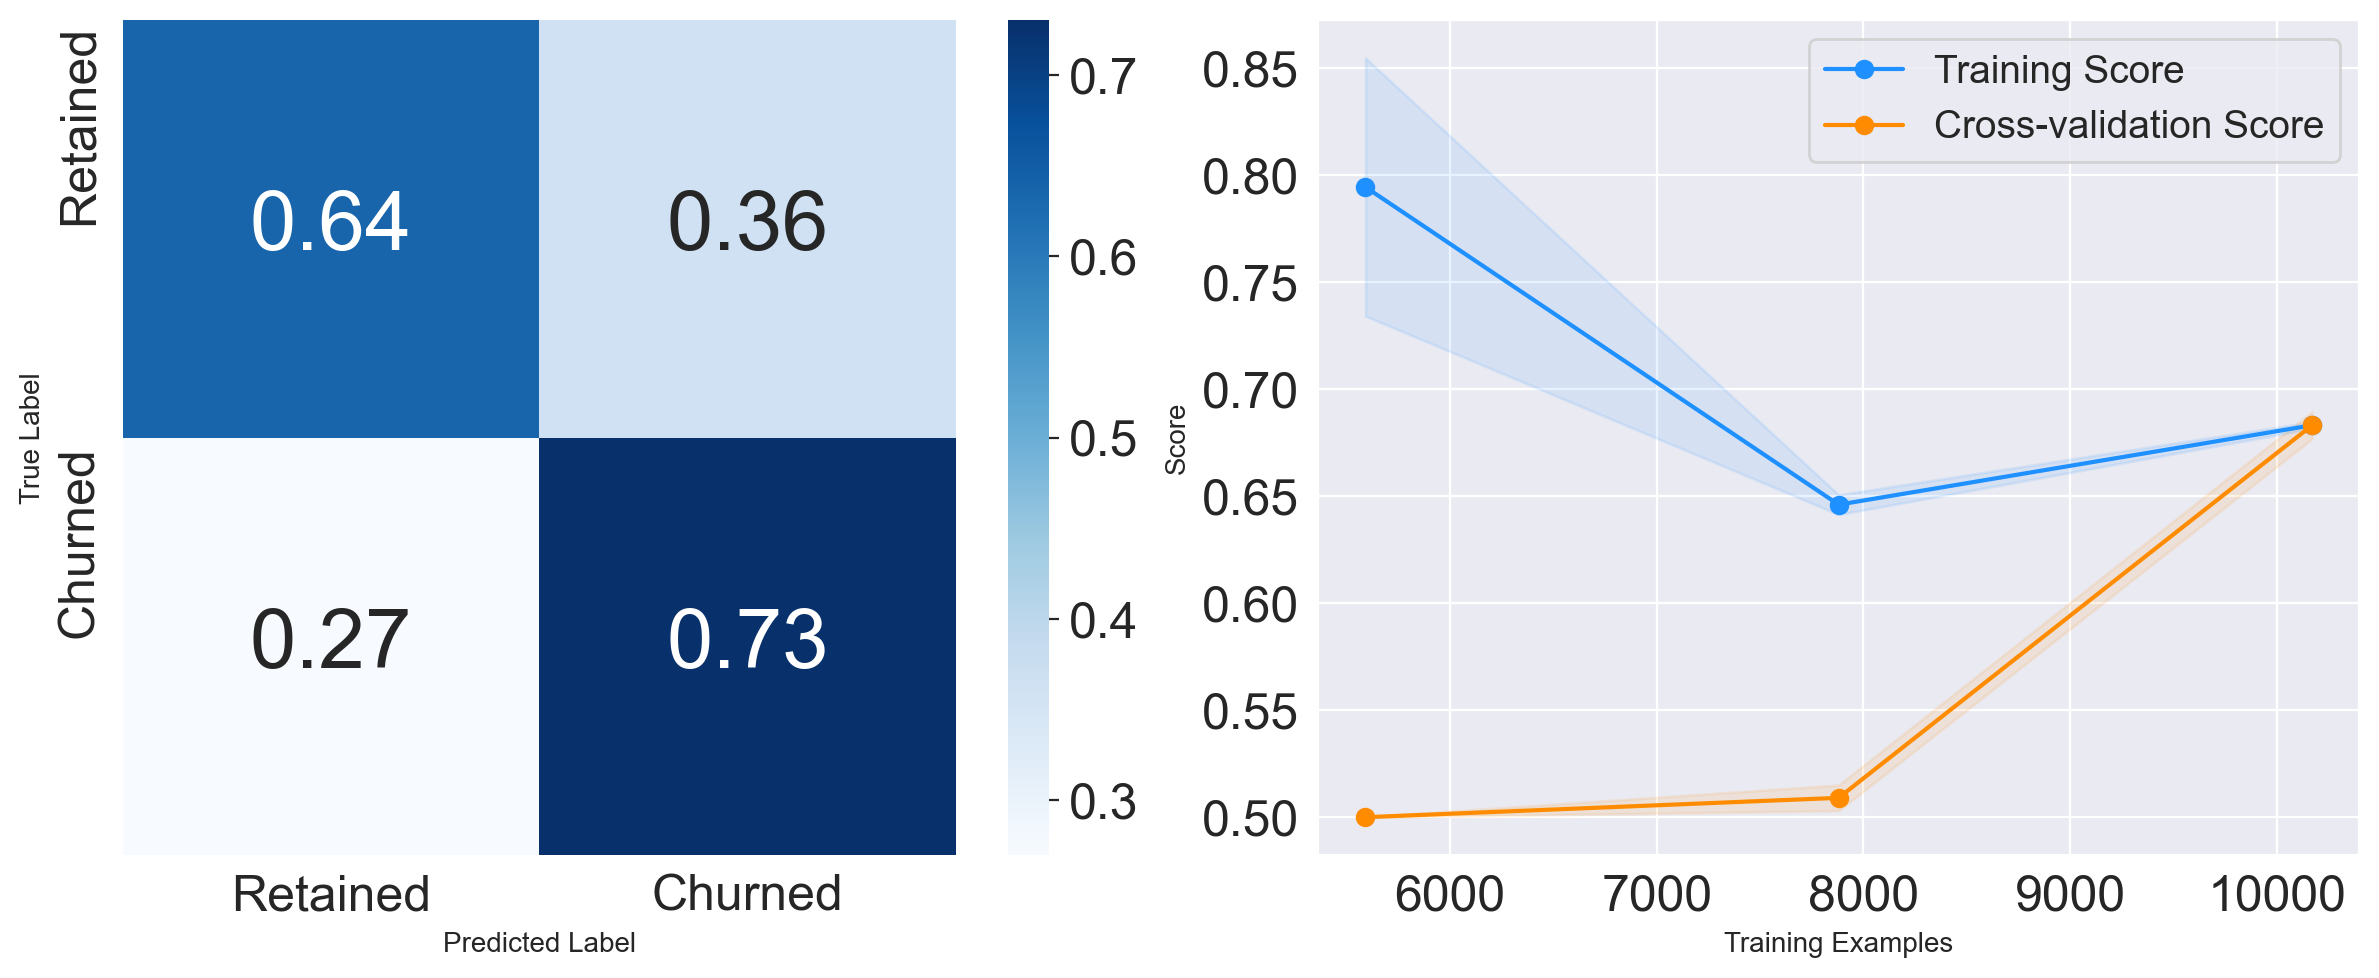

In [ ]:
lr = LogisticRegression(random_state=random_state)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')

### Support Vector Classifier

In [ ]:
svc = SVC(probability=True, random_state=random_state)

param_grid = tuned_parameters = [{'kernel': ['rbf'],
                                  'gamma': ['scale', 'auto'],
                                  'C': [.1, 1, 2]},
                                 {'kernel': ['linear'],
                                  'C': [.1, 1, 10]}
                                ]

svc_clf = GridSearchCV(estimator=svc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_svc_clf = svc_clf.fit(X_train, y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC')

KeyboardInterrupt: 

### Random Forest


 Random Forest
-------------------------------
   Best Score (recall): 0.77
   Best Parameters: 
      bootstrap: True
      criterion: gini
      max_depth: 6
      max_features: auto
      min_samples_leaf: 5
      min_samples_split: 2
      n_estimators: 100


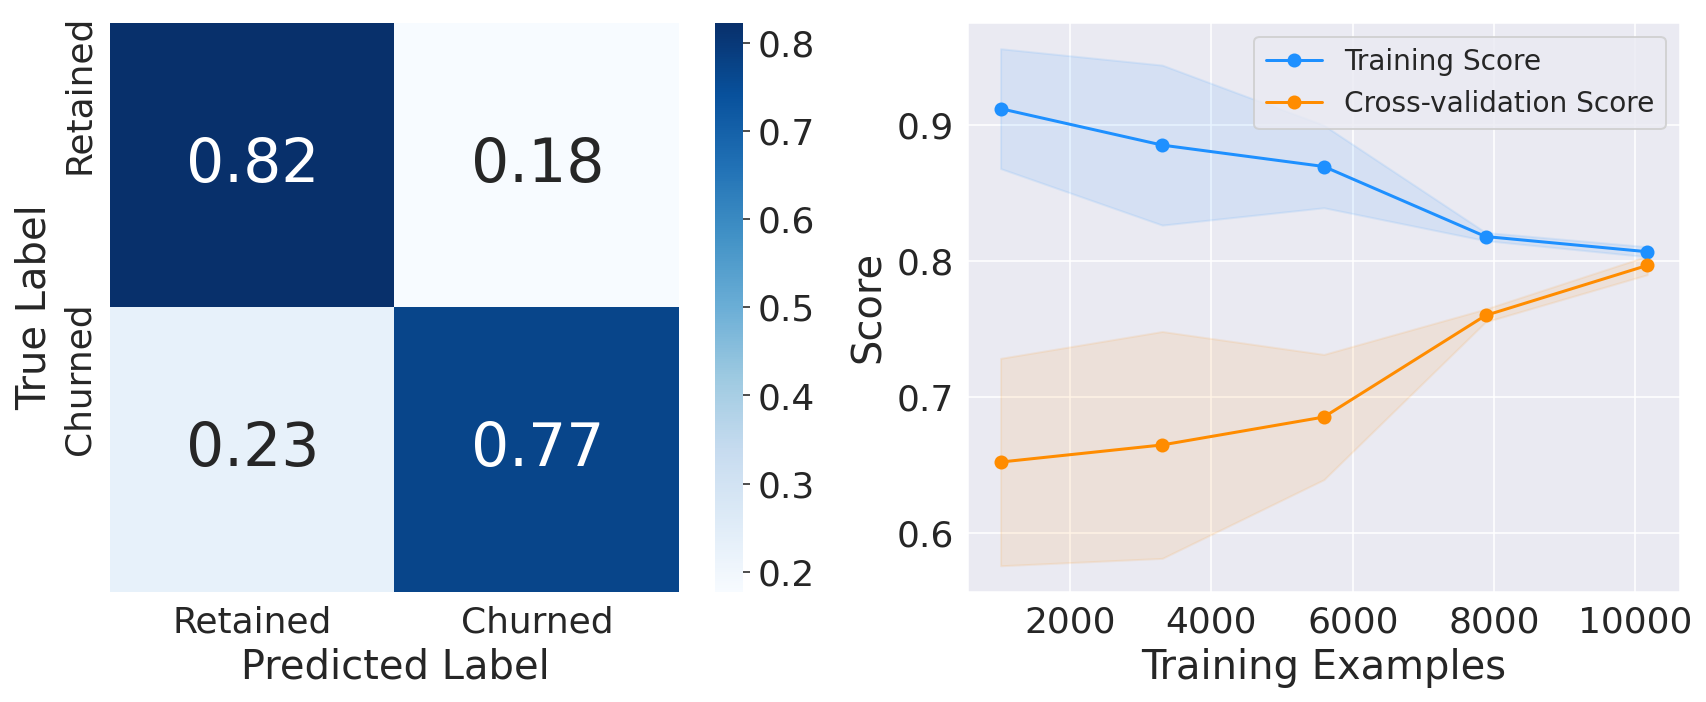

In [ ]:
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

### Gradient Boosting Classifier


 Gradient Boosting Classifier
-------------------------------
   Best Score (recall): 0.755
   Best Parameters: 
      learning_rate: 0.01
      max_depth: 3
      max_features: auto
      min_samples_leaf: 3
      min_samples_split: 5
      n_estimators: 600
      n_iter_no_change: 20
      subsample: 0.66
      tol: 0.01
      validation_fraction: 0.2


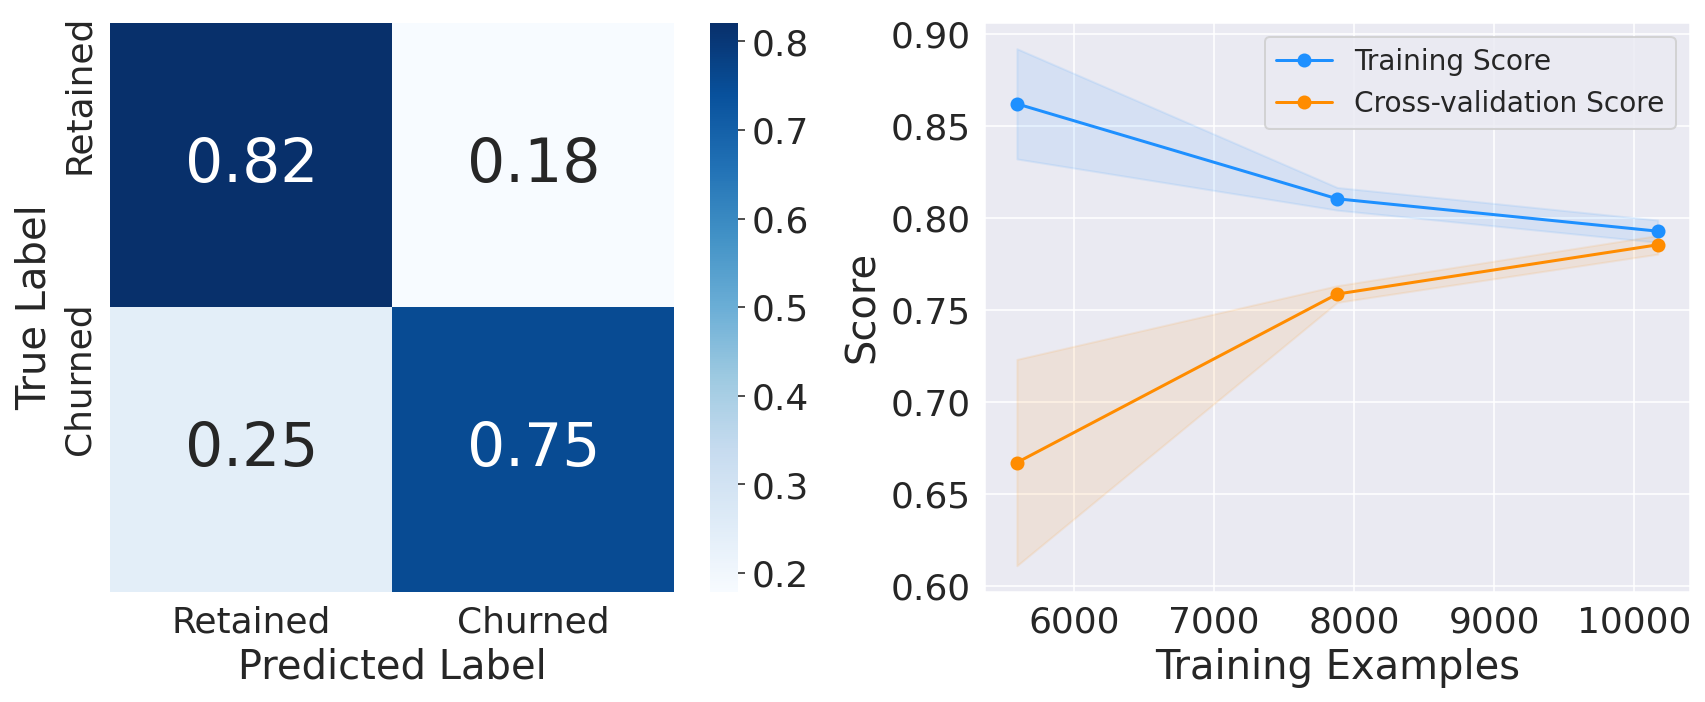

In [ ]:
gbc = GradientBoostingClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [600],
    'subsample': [0.66, 0.75],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3],  # default=3
    'min_samples_split': [5, 7],
    'min_samples_leaf': [3, 5],
    'max_features': ['auto', 'log2', None],
    'n_iter_no_change': [20],
    'validation_fraction': [0.2],
    'tol': [0.01]
}

gbc_clf = GridSearchCV(estimator=gbc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_gbc_clf = gbc_clf.fit(X_train, y_train)
clf_performance(best_gbc_clf, 'Gradient Boosting Classifier', 'GBC')

The number of estimators after early stopping is: 

In [ ]:
best_gbc_clf.best_estimator_.n_estimators_

284

### XGBoost Classifier

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.781
   Best Parameters: 
      colsample_bytree: 0.5
      gamma: 1
      learning_rate: 0.01
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 1
      reg_lambda: 1
      subsample: 0.75


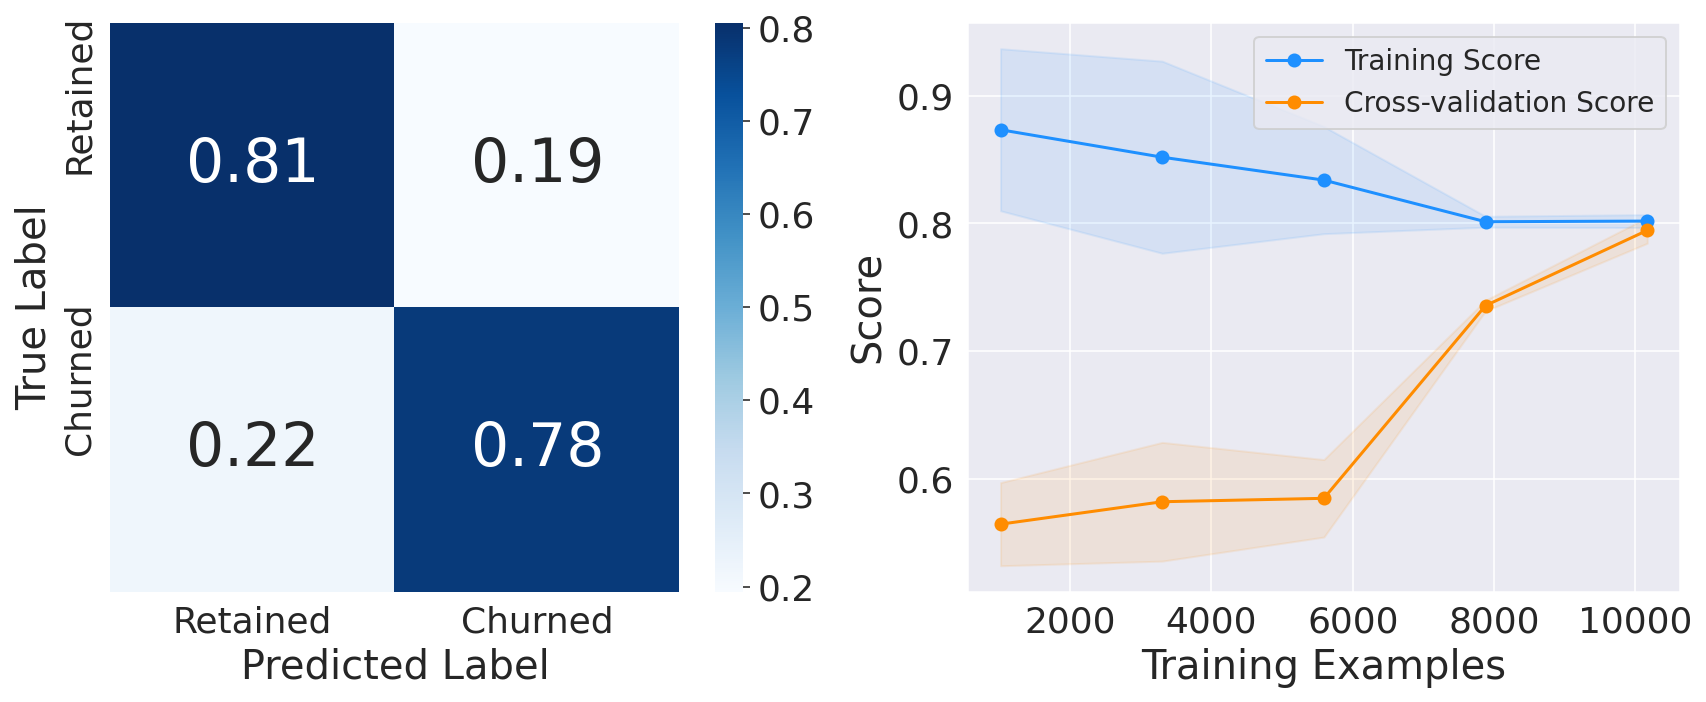

In [ ]:
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],  # default=6
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')

### LGBMClassifier

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 LGBMClassifier
-------------------------------
   Best Score (recall): 0.78
   Best Parameters: 
      feature_fraction: 0.5
      learning_rate: 0.01
      max_depth: 5
      min_child_samples: 10
      n_estimators: 200
      num_leaves: 10
      reg_alpha: 0.1
      reg_lambda: 0.5


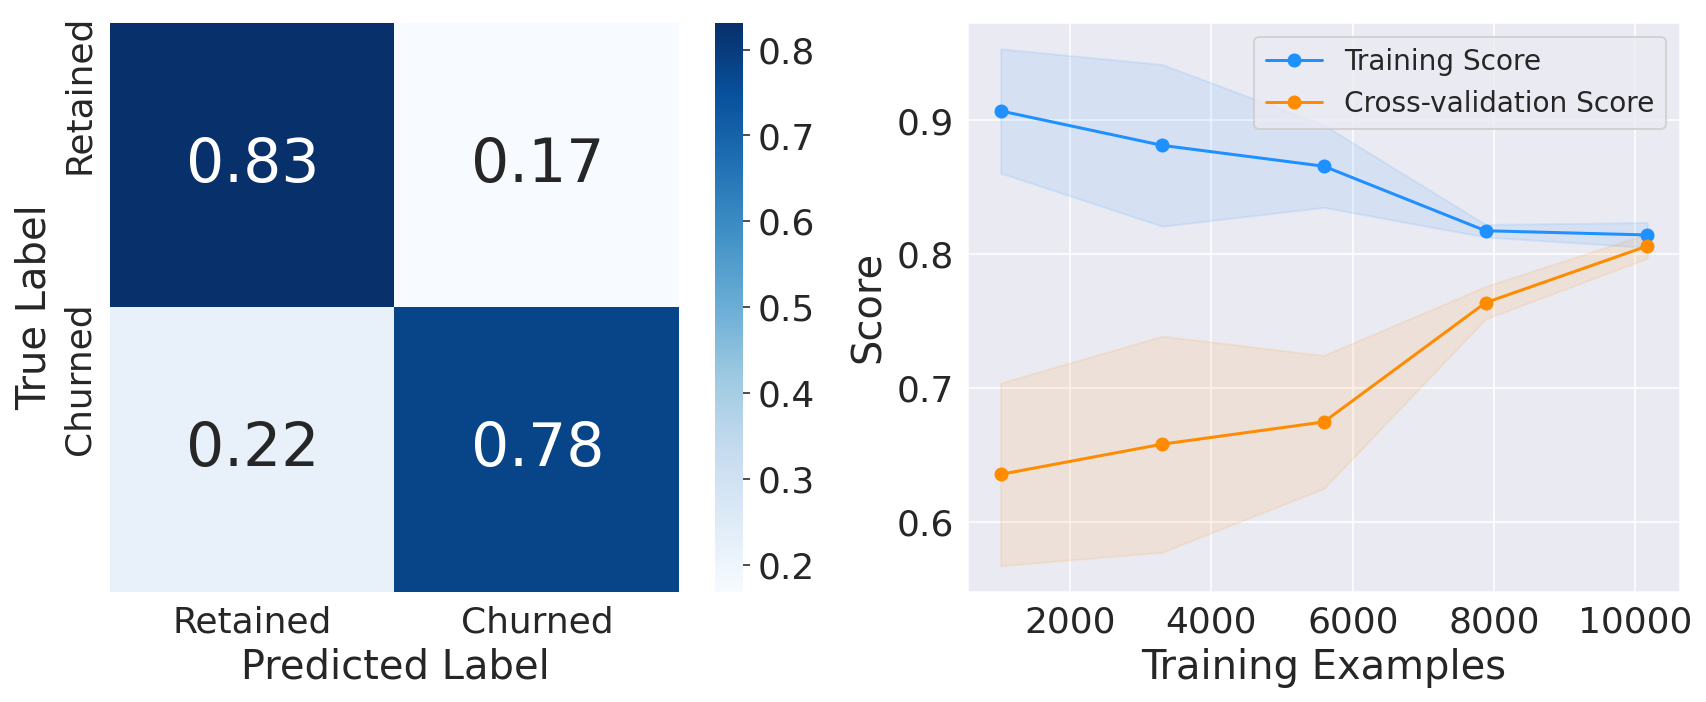

In [ ]:
lgbmc = LGBMClassifier(random_state=random_state)

param_grid = {
    'max_depth': [5],
    'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [200],
    'feature_fraction': [0.5],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

lgbmc_clf = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring=scoring_metric,
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

best_lgbmc_clf = lgbmc_clf.fit(X_train, y_train)
clf_performance(best_lgbmc_clf, 'LGBMClassifier', 'LGBMC')

### Ensemble Learning

We can combine the predictions of all these classifiers to determine if we get better predictive performance compared to each individual constituent classifier. This practice is the main motivation behind Ensemble Learning.

Specifically, I will use **Soft Voting**. In this case, every individual classifier provides a probability value that a specific data point belongs to a particular target class. The predictions are weighted by the classifier's importance and summed up. Then the target label with the greatest sum of weighted probabilities wins the vote.


Soft Voting
-----------------
  Recall:  0.785


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


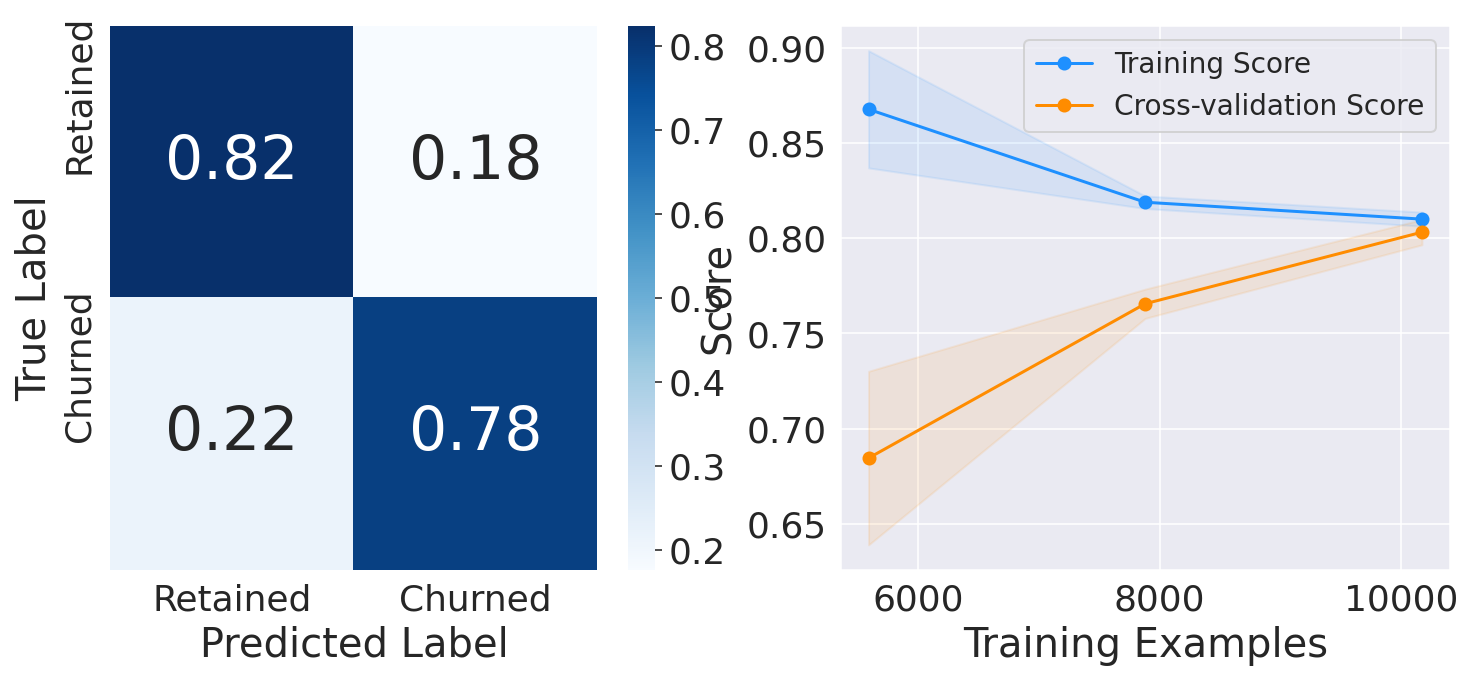

In [ ]:
estimators = [('LR', best_lr_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('GBC', best_gbc_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('LGBMC', best_lgbmc_clf.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
                                     voting='soft',
                                     n_jobs=-1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              y_train,
                              cv=5,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [
    accuracy_score(y_train, y_pred),
    precision_score(y_train, y_pred),
    recall_score(y_train, y_pred),
    roc_auc_score(y_train, y_pred_pp), fpr, tpr
]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_conf_mx(cm, ax1)
plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)

<br>

# Results

## Learning Curves

For all models, there is a tiny gap between the two curves at the end of training. This observation indicates that we do **not** overfit the training set. 

## Feature Importance

Some classifiers allow us to visualise feature importance:

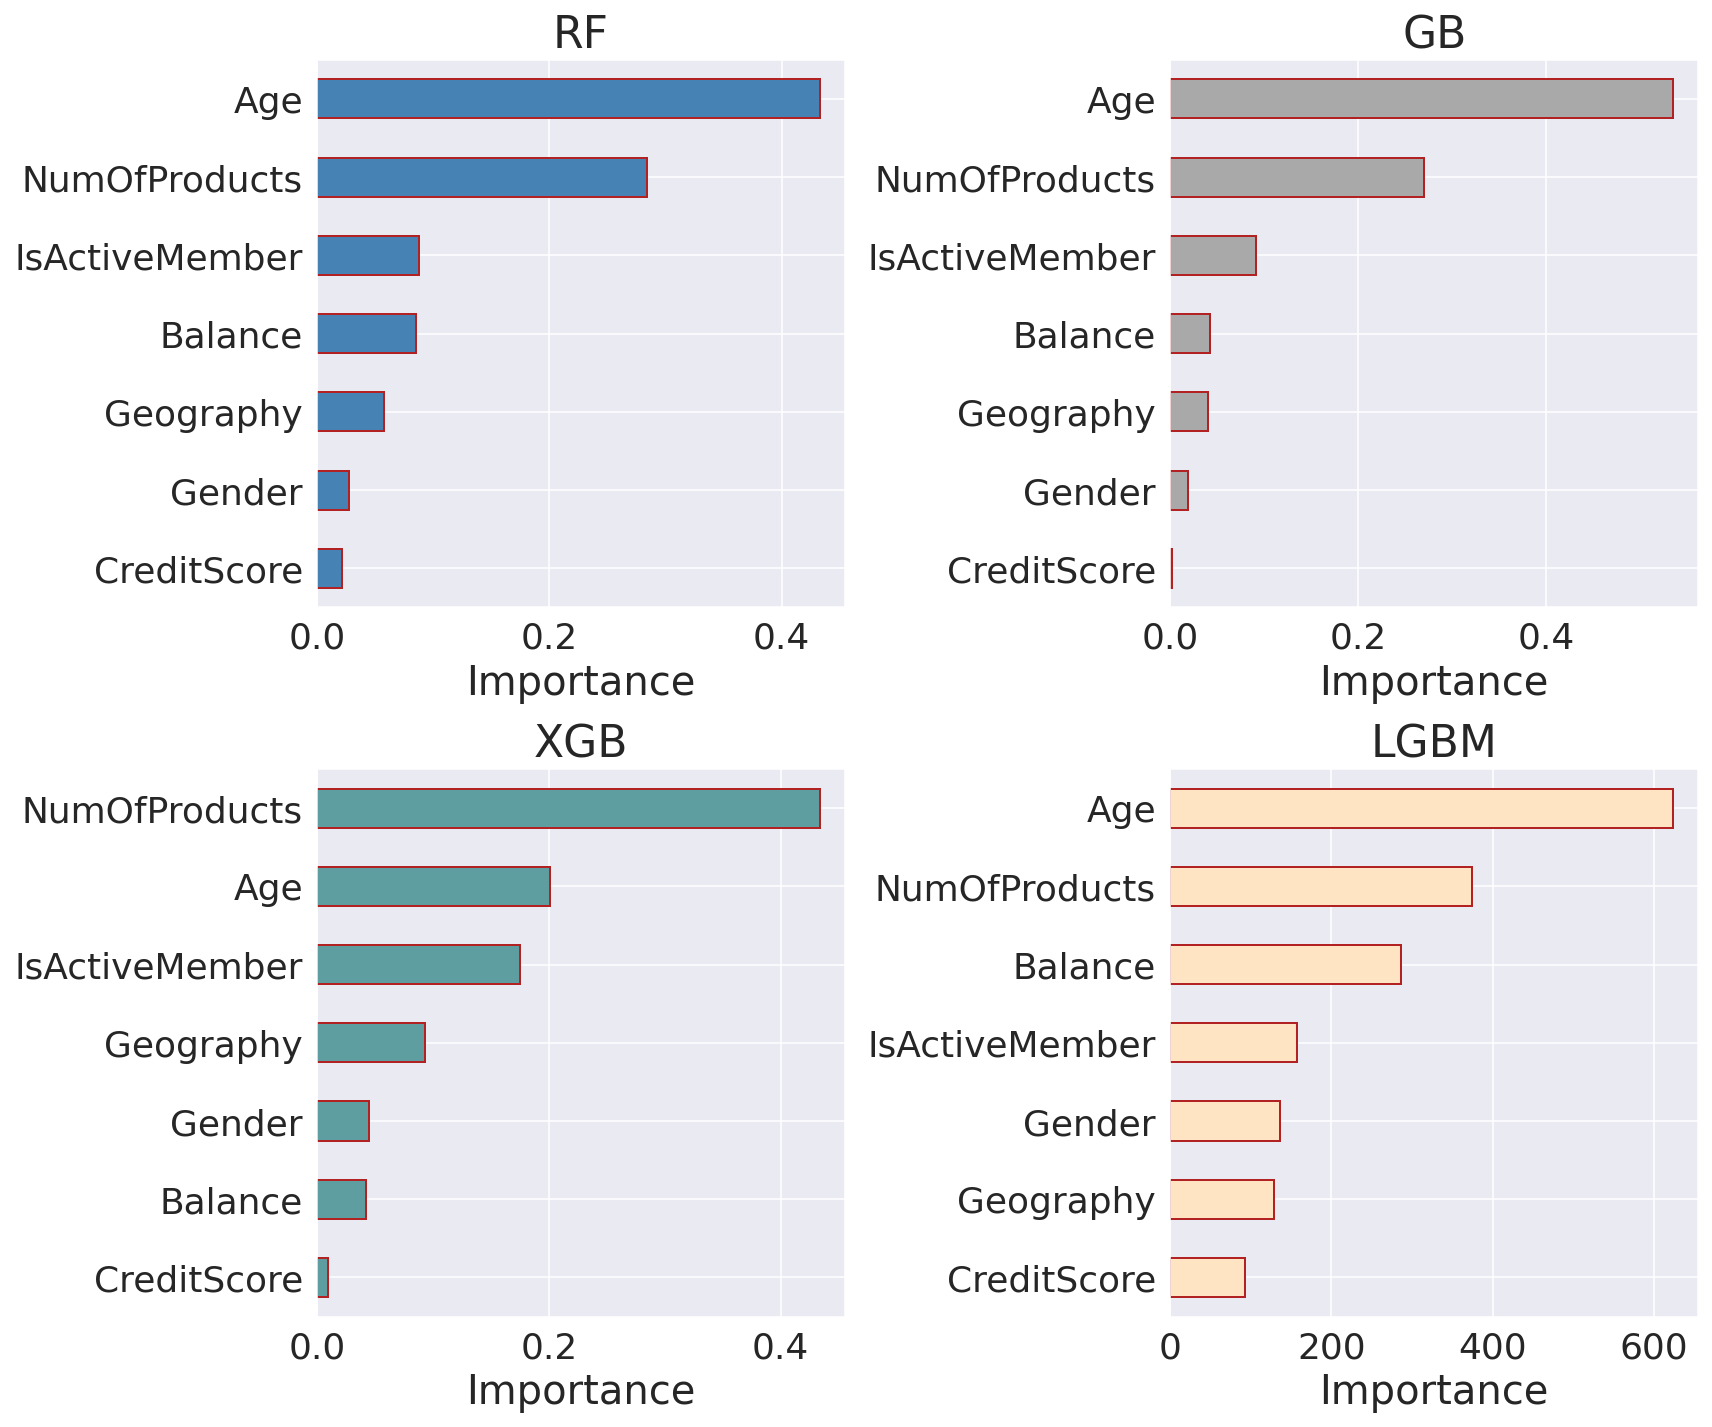

In [ ]:
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(2, 2, figsize=(12, 10))

for i, (name, clf) in enumerate(zip(['RF', 'GB', 'XGB', 'LGBM'],
                                    [best_rf_clf, best_gbc_clf, best_xgb_clf, best_lgbmc_clf])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')

plt.tight_layout();

'Age' and 'NumOfProducts' seem like the most useful features for all classifiers, followed by 'IsActiveMember' and 'Balance'. On the other hand, 'CreditScore' is the least important feature with a small value close to zero for all estimators apart from LGBM. 

## Performance Comparison

Initially, we can compare the performance of our classifiers in terms of four individual metrics (Accuracy, precision, recall, and area under the ROC curve or simply AUC):

In [ ]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

,Accuracy,Precision,Recall,AUC
LR,0.683,0.667,0.730,0.734
SVC,0.797,0.808,0.780,0.876
RF,0.796,0.813,0.770,0.883
GBC,0.788,0.808,0.755,0.875
XGB,0.793,0.800,0.781,0.876
LGBMC,0.805,0.822,0.780,0.888
SVot,0.804,0.816,0.785,0.887


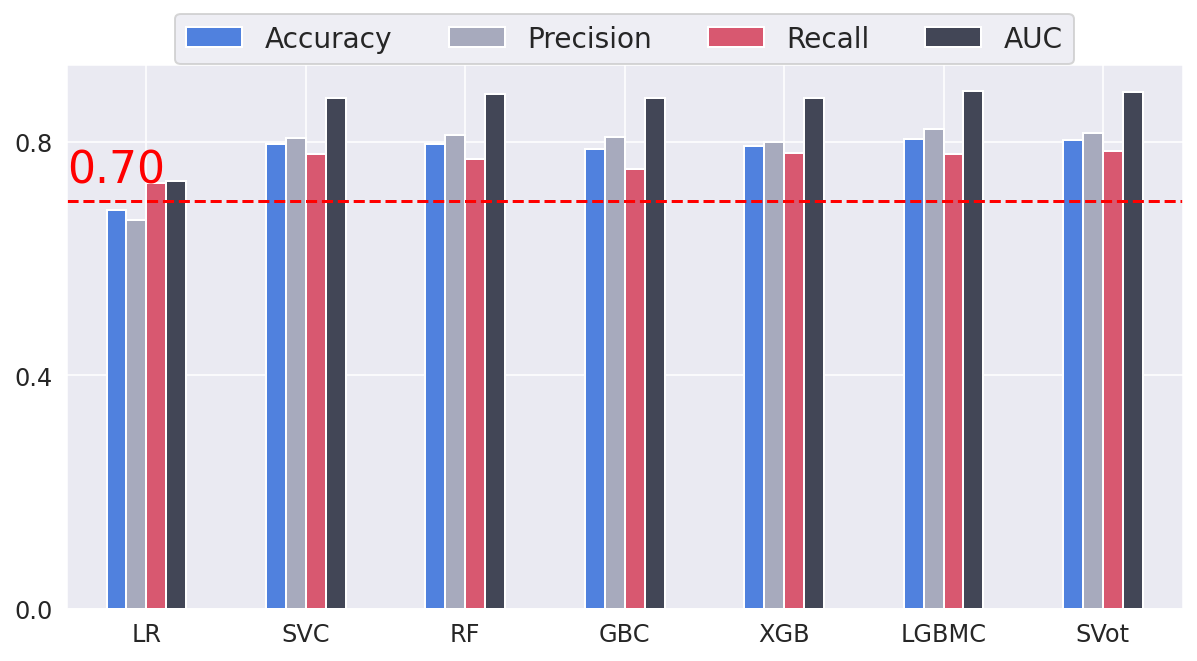

In [ ]:
comparison_df.plot(kind='bar',
                   figsize=(10, 5),
                   fontsize=12,
                   color=['#5081DE', '#A7AABD', '#D85870', '#424656'])

plt.legend(loc='upper center',
           fontsize=font_size - 6,
           ncol=len(comparison_df.columns),
           bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.73, s='0.70', size=font_size + 2, color='red');

All other classifiers have a recall higher than 70% (baseline performance). XGB is the model with the highest recall (78.5 %). However, the LGBM classifier has the best overall performance with the highest accuracy, precision, and AUC.

Using single metrics is not the only way of comparing the predictive performance of classification models. The ROC curve (Receiver Operating Characteristic curve) is a graph showing the performance of a classifier at different classification thresholds. It plots the true positive rate (another name for recall) against the false positive rate.

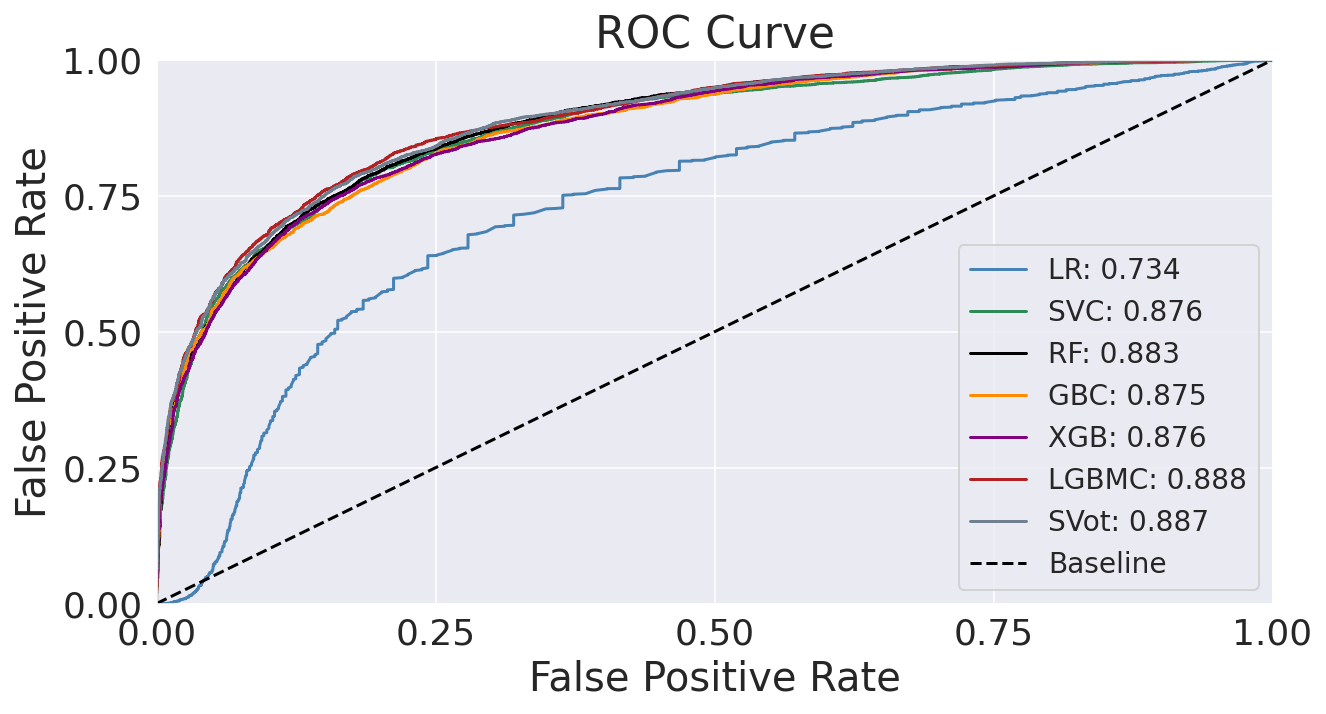

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr,
            tpr,
            color=colors_comp[index],
            label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('False Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14);

The dashed diagonal line represents a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

In our case, all classifiers, apart from Logistic Regression, perform similarly. It seems that LGBM performs marginally better, as evidenced by the slightly higher AUC (0.888).

Recently, I came across another tool for assessing the performance of a classifier model. Simply put, a Cumulative Gain shows the percentage of targets reached when considering a certain percentage of the population with the highest probability to be target according to the model (see [here](https://towardsdatascience.com/meaningful-metrics-cumulative-gains-and-lyft-charts-7aac02fc5c14) and [here](http://mlwiki.org/index.php/Cumulative_Gain_Chart)). The `scikitplot` library offers an easy way of plotting this chart:

Soft Voting:


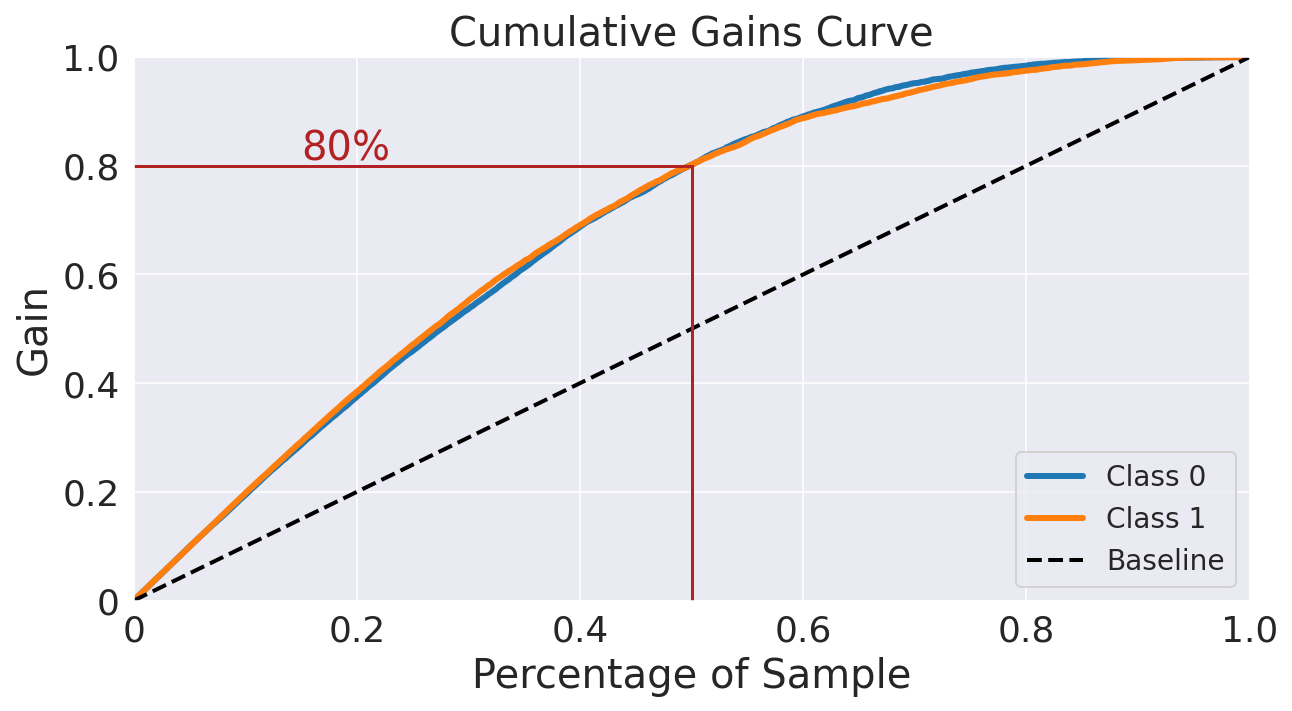

In [ ]:
print('Soft Voting:')

y_pred = cross_val_predict(tuned_voting_soft,
                           X_train,
                           y_train,
                           cv=5,
                           method='predict_proba')

fig, ax = plt.subplots(figsize=(10, 5))

skplt.metrics.plot_cumulative_gain(y_train, y_pred, ax=ax)

ax.plot([0.5, 0.5], [0, 0.8], color='firebrick')
ax.plot([0.0, 0.5], [0.8, 0.8], color='firebrick')

ax.set_title('Cumulative Gains Curve', size=font_size)
ax.set_xlabel('Percentage of Sample', size=font_size)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.set_ylabel('Gain', size=font_size)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.text(0.15, 0.81, '80%', size=font_size, color='firebrick')
ax.legend(fontsize=14);

This chart shows that if we target 50% of the customers most likely to churn (according to the model), the model will pick 80% of customers who will actually churn, while the random pick would pick only 50% of the targets.

<br>

# Evaluating the Test Set

Now is the time to evaluate the models on unseen data. First, we need to perform the same preprocessing steps as the training set.

In [ ]:
test_df = test_df.drop(features_drop, axis=1)

test_df['Gender'] = LabelEncoder().fit_transform(test_df['Gender'])
test_df['Geography'] = test_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

test_df[scl_columns] = scaler.transform(test_df[scl_columns])  # not fit_transform, scaler has already been trained

y_test = test_df['Exited']
X_test = test_df.drop('Exited', 1)

print('✔️ Preprocessing Complete!')

✔️ Preprocessing Complete!


<br>

We will use the same method for comparing our classifiers as we did in the training set.

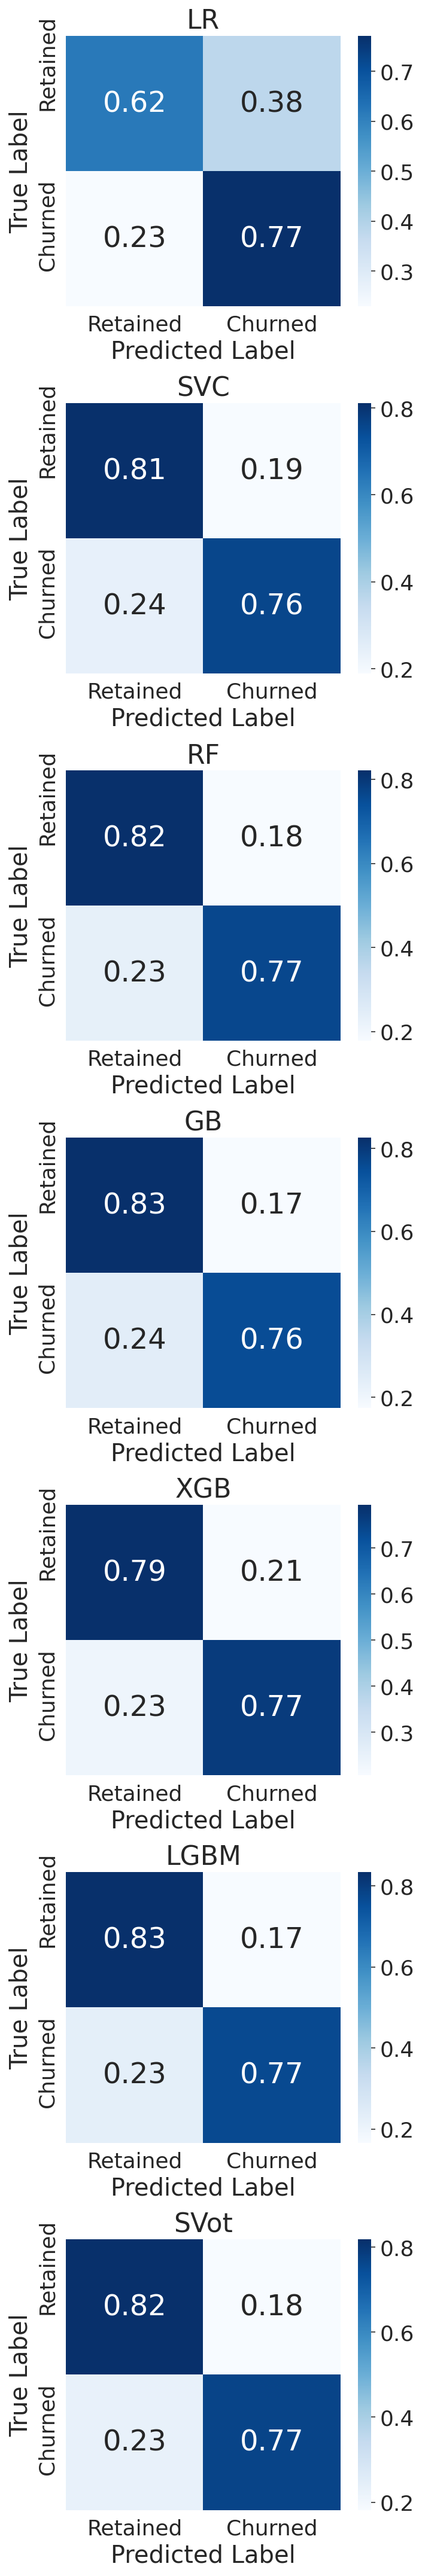

In [ ]:
tuned_voting_soft.fit(X_train, y_train)

fig, ax = plt.subplots(7, 1, figsize=(5, 30))

for i, (name, clf) in enumerate(zip(['LR', 'SVC', 'RF', 'GB', 'XGB', 'LGBM', 'SVot'], 
                                    [best_lr_clf.best_estimator_, best_svc_clf.best_estimator_, best_rf_clf.best_estimator_, best_gbc_clf.best_estimator_, best_xgb_clf.best_estimator_, best_lgbmc_clf.best_estimator_, tuned_voting_soft])):
    test_func(clf, name, ax=ax[i])

plt.tight_layout();

In [ ]:
comparison_test_df = pd.DataFrame(comparison_test_dict,
                                  index=['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color='indianred', axis=0)

,Accuracy,Precision,Recall
LR,0.650,0.332,0.771
SVC,0.801,0.496,0.758
RF,0.811,0.513,0.766
GB,0.812,0.516,0.756
XGB,0.788,0.476,0.766
LGBM,0.822,0.532,0.771
SVot,0.809,0.509,0.771


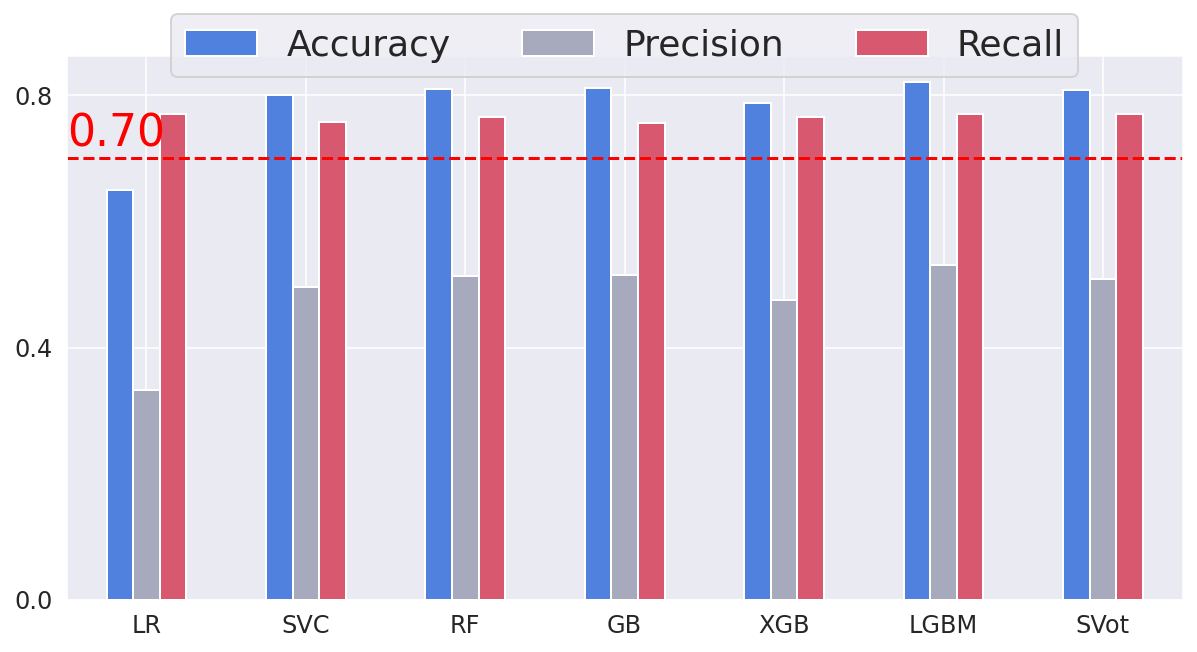

In [ ]:
comparison_test_df.plot(kind='bar',
                        figsize=(10, 5),
                        fontsize=12,
                        color=['#5081DE', '#A7AABD', '#D85870'])

plt.legend(loc='upper center',
           ncol=len(comparison_test_df.columns),
           bbox_to_anchor=(0.5, 1.11))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.72, s='0.70', size=font_size + 2, color='red');

The performance on the test set for all models is fairly similar to the training set, which proves that we do **not** overfit the training set. Therefore, we can predict customer churn with a recall approximately equal to **78%**.

<br>

# Bibliography

The main resources I used are the following two books:

[1] **[Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), by Aurélien Géron (2019)**

[2] **[Practical Statistics for Data Scientists, 2nd Edition](https://www.oreilly.com/library/view/practical-statistics-for/9781492072935/), by Peter Bruce, Andrew Bruce, and Peter Gedeck (2020)**

<br>

The following resources (Retrieved on mid-December 2020) also helped me in my analysis:

[3] [Bank Customer Churn](https://rstudio-pubs-static.s3.amazonaws.com/565148_6e82a5c320f14869bf63e23bcf59ce9b.html#compare-models-performance), by Zicheng Shi (same dataset but analysis in R)

[4] [Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html) on [scikit-learn.org](https://scikit-learn.org/stable/modules/model_evaluation.html)

[5] [Easy Guide To Data Preprocessing In Python](https://www.kdnuggets.com/2020/07/easy-guide-data-preprocessing-python.html), by Ahmad Anis

[6] [Meaningful Metrics: Cumulative Gains and Lyft Charts](https://towardsdatascience.com/meaningful-metrics-cumulative-gains-and-lyft-charts-7aac02fc5c14), by Raffi Sahakyan

<br>

If you would like to read more about customer churn:

[7] [Churn Rate](https://www.investopedia.com/terms/c/churnrate.asp), by Jake Frankenfield on [Investopedia](https://www.investopedia.com/)

[8] [Customer attrition](https://en.wikipedia.org/wiki/Customer_attrition) on [Wikipedia](https://en.wikipedia.org/wiki/Main_Page)

[9] [A Survey on Churn Prediction Techniques in Communication Sector](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.278.4171&rep=rep1&type=pdf), by N.Kamalraj and A.Malathi

[10] [Customer Attrition](https://www.optimove.com/resources/learning-center/customer-attrition) on [optimove](https://www.optimove.com/resources/learning-center/customer-attrition)

<br>

# Future Development

-  I tried combining existing features to produce more useful ones (Feature Engineering). However, this didn’t increase the predictive performance of my models. Feature engineering can prove quite important when done right, so it is worth exploring in a future version of this notebook.

<br>

# Conclusions

Our notebook just came to an end! Our final report to the bank should be based on two main points:

- **EDA** can help us identify which features contribute to customer churn. Additionally, **feature importance** analysis can quantify the importance of each feature in predicting the likelihood of churn. Our results reveal that the most significant feature is **age** (older customers are more likely to churn), followed by the **number of products** (having more products increases a customer’s likelihood to churn). The bank could use our findings to adapt and improve its services in a way that increases satisfaction for those customers more likely to churn.

- We can build several **machine learning models** with **recall** approximately equal to **78%**, meaning that they can successfully detect almost 80% of those customers more luckily to churn. Perhaps, adding more features or/and records could help us improve predictive performance. Therefore, the bank could benefit from investing in gathering more data.

<br>

Please feel free to make any suggestions for improving my analysis. Also,  please consider <font size=+0 color="red"><b>upvoting</b></font> if you found this notebook useful. Thank you! 😉